<a href="https://colab.research.google.com/github/jhj1819/Machine-learning/blob/main/AI%EC%99%80_%EC%9D%B8%EA%B0%84_%ED%85%8D%EC%8A%A4%ED%8A%B8_%ED%8C%90%EB%B3%84_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. # Google Drive 마운트 & 프로젝트 폴더 준비

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

from pathlib import Path
DATA_DIR = Path('/content/drive/MyDrive/llmdetect')
for sub in ['data/raw', 'data/processed', 'eda/figures',
            'models', 'outputs', 'scripts', 'notebooks']:
    (DATA_DIR / sub).mkdir(parents=True, exist_ok=True)
print("DATA_DIR =", DATA_DIR)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
DATA_DIR = /content/drive/MyDrive/llmdetect


In [ ]:
import pandas as pd, numpy as np, joblib, os, gc, time
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
import xgboost as xgb
from pathlib import Path

# 2. 데이터 로드 & 1차 EDA

## 2-1 데이터 불러오기

In [ ]:
import pandas as pd

train = pd.read_csv(DATA_DIR / 'train.csv',
                    dtype={'label': 'category'}, memory_map=True)
test  = pd.read_csv(DATA_DIR / 'test.csv',  memory_map=True)   # test 없으면 주석

print("train shape:", train.shape)
display(train.head())

train shape: (97172, 3)


,title,full_text,generated
0,카호올라웨섬,카호올라웨섬은 하와이 제도를 구성하는 8개의 화산섬 가운데 하나로 면적은 115.5...,0
1,청색거성,"천문학에서 청색거성(靑色巨星, )은 광도 분류에서 III형(거성) 또는 II형(밝은...",0
2,엘자스-로트링겐 평의회 공화국,엘자스-로트링겐 평의회 공화국은 1차대전 말기 독일 혁명 와중에 엘자스-로트링겐에서...,0
3,윌리엄 페니 브룩스,"윌리엄 페니 브룩스(, 1809년 8월 13일 ~ 1895년 12월 11일)는 잉글...",0
4,미그로,"미그로 또는 미그로스(""Migros"")는 스위스 최대 소매 회사이자, 최대 슈퍼마켓...",0


## 2-2 라벨 비율 및 텍스트 길이

★ 라벨 개수
 generated
0    89177
1     7995
Name: count, dtype: int64 

★ 비율
 generated
0    0.917723
1    0.082277
Name: count, dtype: float64
📈 히스토그램 저장: /content/drive/MyDrive/llmdetect/eda/figures/len_hist.png


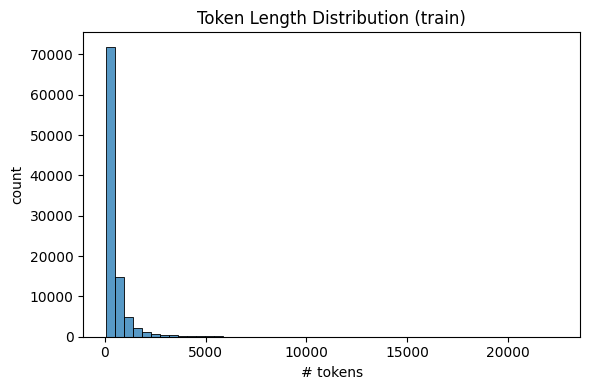

In [ ]:
import matplotlib.pyplot as plt, seaborn as sns

# 1) 라벨 분포  ── 'generated'가 1이면 AI, 0이면 Human
label_counts = train['generated'].value_counts()
label_ratio  = label_counts / len(train)
print("★ 라벨 개수\n", label_counts, "\n\n★ 비율\n", label_ratio)

# 2) 텍스트 길이(단어 수) 분포
train['len_tokens'] = train['full_text'].str.split().str.len()

plt.figure(figsize=(6,4))
sns.histplot(train['len_tokens'], bins=50)
plt.title('Token Length Distribution (train)')
plt.xlabel('# tokens'); plt.ylabel('count')
plt.tight_layout()

# 3) 그래프 자동 저장
fig_path = DATA_DIR / 'eda/figures/len_hist.png'
plt.savefig(fig_path)
print("📈 히스토그램 저장:", fig_path)


라벨 비율: 심한 불균형
토큰 길이 분포: 대부분 2000토큰. PLM 입력 512토큰 제한 -> 잘라내기 필요

> 불균형 지표
scale_pos_weight ≈ 89 177 / 7 995 ≃ 11.2
⇒ XGBoost · 손실함수 가중치에 그대로 사용

# 3. TF-IDF, 교차검증

## 3.1 TF-IDF

"제목+본문"을 TF-IDF로 문자 n-gram 특징 벡터로 만들어서 AI 작성 여부를 판별하는 모델에 입력할 수 있도록 준비하는 과정

In [ ]:


# ── 1) 데이터
train = pd.read_csv(DATA_DIR/'train.csv', dtype={'generated':'int8'})
X_text = train['title'] + ' ' + train['full_text']      # title + 본문 합치기
y      = train['generated'].values

# ── 2) TF-IDF (char 3-5gram + word 1-2gram)
tfidf = TfidfVectorizer(
    analyzer='char', ngram_range=(3,5), min_df=3, max_features=300_000,
    sublinear_tf=True, lowercase=False)
X_char = tfidf.fit_transform(X_text)

# (옵션) 단어 n-gram을 합치고 싶다면 아래 주석 해제
# word_tfidf = TfidfVectorizer(
#     analyzer='word', ngram_range=(1,2), min_df=3, max_features=100_000,
#     stop_words=None, lowercase=True)
# X_word = word_tfidf.fit_transform(X_text)
# from scipy.sparse import hstack
# X = hstack([X_char, X_word])
X = X_char

print("Vectorized shape:", X.shape)


Vectorized shape: (97172, 300000)


**TF-IDF (Term Frequency-Inverse Document Frequency)**는 문서에서 단어(또는 n-gram)의 중요도를 수치화하는 방법
- '는', '이', 'the', 'a' 같은 모든 문서에 흔한 단어는 낮은 가중치.
- 특정 문서에서만 자주 등장하는 핵심 키워드나 표현은 높은 가중치

In [ ]:
import scipy.sparse as sp
import joblib

# ── TF-IDF 벡터라이저 저장
joblib.dump(tfidf, DATA_DIR/'models/tfidf_char.pkl')

# ── 희소행렬 저장
sp.save_npz(DATA_DIR/'data/processed/X_char.npz', X_char)

print("✔️ TF-IDF 벡터라이저 & 희소행렬 저장 완료")


✔️ TF-IDF 벡터라이저 & 희소행렬 저장 완료


In [ ]:
import scipy.sparse as sp
import joblib

# ── 벡터라이저 복원
tfidf = joblib.load(DATA_DIR/'models/tfidf_char.pkl')

# ── 희소행렬 복원
X_char = sp.load_npz(DATA_DIR/'data/processed/X_char.npz')

X = X_char  # 필요하다면 word n-gram 합치기 등 추가

print("✔️ 로드 완료:", X.shape)


## 3.2 교차검증

- 1️⃣ TF-IDF로 만든 희소 행렬(X) 을 XGBoost의 DMatrix로 - 변환
- 2️⃣ **Stratified K-Fold 교차검증(CV)**으로 모델 검증 안정성 확보
- 3️⃣ XGBoost 이진분류 (binary:logistic) → ROC-AUC로 성능 평가
- 4️⃣ Fold별 모델 저장 + OOF 예측 산출
- 5️⃣ VRAM 모니터링 (nvidia-smi 활용)

In [ ]:
import xgboost as xgb, numpy as np, gc, subprocess, os, sys
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

def show_gpu_mem(note=""):
    """간단한 VRAM 스냅샷; 필요 없으면 주석 처리 가능"""
    try:
        out = subprocess.check_output(["nvidia-smi", "--query-gpu=memory.used", "--format=csv,nounits,noheader"])
        used = int(out.decode().strip().split('\n')[0])
        print(f"[GPU] {note} used {used} MiB")
    except Exception as e:
        print("[GPU] nvidia-smi unavailable:", e)

# ── 3) XGBoost 파라미터 (예시: 경량 버전, 값은 상황 맞춰 수정)
pos_weight = (y == 0).sum() / (y == 1).sum()
params = {
    'objective'       : 'binary:logistic',
    'eval_metric'     : 'auc',
    'scale_pos_weight': pos_weight,
    'tree_method'     : 'gpu_hist',  # GPU 강제
    'max_bin'         : 32,
    'subsample'       : 0.4,
    'colsample_bytree': 0.3,
    'max_depth'       : 4,
    'eta'             : 0.1,
    'seed'            : 42,
}

num_round = 800
early_stop = 100

# ── 4) 5-fold CV
kf        = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
oof_pred  = np.zeros(len(train))
fold_auc  = []

show_gpu_mem("baseline")

for fold, (tr_idx, val_idx) in enumerate(kf.split(X, y), 1):
    print(f"\n▶️ Fold {fold} start")
    show_gpu_mem("before DMatrix")

    # --- DMatrix 생성
    dtrain = xgb.DMatrix(X[tr_idx], label=y[tr_idx])
    dval   = xgb.DMatrix(X[val_idx], label=y[val_idx])

    show_gpu_mem("after DMatrix")

    # --- 학습
    model = xgb.train(
        params,
        dtrain,
        num_boost_round       = num_round,
        evals                 = [(dval, 'val')],
        early_stopping_rounds = early_stop,
        verbose_eval          = 100
    )

    # --- 평가
    pred = model.predict(dval, iteration_range=(0, model.best_iteration + 1))
    auc  = roc_auc_score(y[val_idx], pred)
    fold_auc.append(auc);  oof_pred[val_idx] = pred
    print(f"✅ Fold {fold} AUC: {auc:.4f} | best_iter: {model.best_iteration}")

    # --- 모델 저장
    model.save_model(DATA_DIR / f"models/xgb_fold{fold}.json")

    # --- 메모리 해제
    del dtrain, dval, model, pred
    gc.collect()
    try:
        import torch; torch.cuda.empty_cache()
    except ImportError:
        pass

    show_gpu_mem("after cleanup")

print("\nCV AUC mean ± std:", np.mean(fold_auc), "±", np.std(fold_auc))

# ── 산출물 저장
np.save(DATA_DIR / 'outputs/oof_pred.npy', oof_pred)
joblib.dump(tfidf, DATA_DIR / 'models/tfidf_char.pkl')
print("Artifacts saved →", DATA_DIR / 'models')


[GPU] baseline used 0 MiB

▶️ Fold 1 start
[GPU] before DMatrix used 0 MiB
[GPU] after DMatrix used 189 MiB


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:36:42] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[0]	val-auc:0.95474
[100]	val-auc:0.99756
[200]	val-auc:0.99793
[300]	val-auc:0.99829
[400]	val-auc:0.99847
[500]	val-auc:0.99854
[600]	val-auc:0.99856
[626]	val-auc:0.99856
✅ Fold 1 AUC: 0.9986 | best_iter: 526


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:39:24] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[GPU] after cleanup used 405 MiB

▶️ Fold 2 start
[GPU] before DMatrix used 405 MiB
[GPU] after DMatrix used 405 MiB


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:39:38] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[0]	val-auc:0.95290
[100]	val-auc:0.99798
[200]	val-auc:0.99838
[300]	val-auc:0.99850
[400]	val-auc:0.99855
[500]	val-auc:0.99855
[600]	val-auc:0.99868
[700]	val-auc:0.99876
[799]	val-auc:0.99880
✅ Fold 2 AUC: 0.9988 | best_iter: 794


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:43:14] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[GPU] after cleanup used 779 MiB

▶️ Fold 3 start
[GPU] before DMatrix used 779 MiB
[GPU] after DMatrix used 405 MiB


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:43:18] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[0]	val-auc:0.94506
[100]	val-auc:0.99728
[200]	val-auc:0.99745
[300]	val-auc:0.99744
[352]	val-auc:0.99735
✅ Fold 3 AUC: 0.9975 | best_iter: 253


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:44:55] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[GPU] after cleanup used 11947 MiB

▶️ Fold 4 start
[GPU] before DMatrix used 777 MiB
[GPU] after DMatrix used 405 MiB


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:44:59] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[0]	val-auc:0.95409
[100]	val-auc:0.99784
[200]	val-auc:0.99827
[300]	val-auc:0.99844
[378]	val-auc:0.99843
✅ Fold 4 AUC: 0.9985 | best_iter: 279


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:46:44] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[GPU] after cleanup used 12313 MiB

▶️ Fold 5 start
[GPU] before DMatrix used 12313 MiB
[GPU] after DMatrix used 405 MiB


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:46:49] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[0]	val-auc:0.94345
[100]	val-auc:0.99746
[200]	val-auc:0.99791
[300]	val-auc:0.99803
[400]	val-auc:0.99809
[500]	val-auc:0.99819
[600]	val-auc:0.99832
[700]	val-auc:0.99832
[799]	val-auc:0.99833
✅ Fold 5 AUC: 0.9984 | best_iter: 771


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:50:25] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[GPU] after cleanup used 12313 MiB

CV AUC mean ± std: 0.9983538189405005 ± 0.00042965633389854016
Artifacts saved → /content/drive/MyDrive/llmdetect/models


- scale_pos_weight ≈ 11.2 : AI(1) 비율 8 % → 양성에 가중치 부여
- gpu_hist : L4 GPU에서 약 3-5 × 가속
- early_stopping_rounds=100 : 과적합 방지 & 훈련 시간 단축

- 추후 최종버전에서는 A100 사용할 예정이므로 성능 강화 가능

## 3.3 테스트 예측 & 제출 파일

In [ ]:
# 1) 로드
import joblib, xgboost as xgb, numpy as np, pandas as pd, scipy.sparse as sp
test = pd.read_csv(DATA_DIR/'test.csv')

tfidf = joblib.load(DATA_DIR/'models/tfidf_char.pkl')

X_test = tfidf.transform(test['title'] + ' ' + test['paragraph_text'])

# 2) 앙상블(5 fold 평균)
preds = np.zeros(X_test.shape[0])
for fold in range(1,6):
    model = xgb.Booster()
    model.load_model(DATA_DIR/f"models/xgb_fold{fold}.json")
    preds += model.predict(xgb.DMatrix(X_test)) / 5

# 3) 제출 파일
sub = pd.DataFrame({
    'ID'        : test['ID'],
    'generated' : preds          # 확률 값
})
sub_path = DATA_DIR/'outputs/sub_tfidf_xgb.csv'
sub.to_csv(sub_path, index=False)
print("📄 제출 파일 저장:", sub_path)


📄 제출 파일 저장: /content/drive/MyDrive/llmdetect/outputs/sub_tfidf_xgb.csv


In [ ]:
# prompt: DATA_DIR/'outputs/sub_tfidf_xgb.csv'
# 이거 지금 어떻게 예측했는지 확인해줄래?
# 확률로 되어있으면 이걸 0또는 1로 이진불류 하고싶어

import pandas as pd
# 예측 결과 파일 로드
sub_df = pd.read_csv(DATA_DIR / 'outputs/sub_tfidf_xgb.csv')

print("예측 결과 파일 확인:")
display(sub_df.head())

# 확률 값을 이진 분류 (0 또는 1)로 변환
# 일반적으로 0.5를 임계값으로 사용하지만, 필요에 따라 조정할 수 있습니다.
threshold = 0.5
sub_df['generated_binary'] = (sub_df['generated'] > threshold).astype(int)

print(f"\n임계값 {threshold}를 적용한 이진 분류 결과:")
display(sub_df.head())

# 이진 분류 결과의 분포 확인
print("\n이진 분류 결과 ('generated_binary') 분포:")
print(sub_df['generated_binary'].value_counts())

# 변환된 결과를 새로운 파일로 저장 (선택 사항)
# sub_binary_path = DATA_DIR / 'outputs/sub_tfidf_xgb_binary.csv'
# sub_df[['ID', 'generated_binary']].to_csv(sub_binary_path, index=False)
# print(f"\n이진 분류 결과 저장 (선택 사항): {sub_binary_path}")


예측 결과 파일 확인:


,ID,generated
0,TEST_0000,0.000463
1,TEST_0001,0.001673
2,TEST_0002,0.000378
3,TEST_0003,0.000829
4,TEST_0004,0.002518



임계값 0.5를 적용한 이진 분류 결과:


,ID,generated,generated_binary
0,TEST_0000,0.000463,0
1,TEST_0001,0.001673,0
2,TEST_0002,0.000378,0
3,TEST_0003,0.000829,0
4,TEST_0004,0.002518,0



이진 분류 결과 ('generated_binary') 분포:
generated_binary
0    1954
1       8
Name: count, dtype: int64


In [ ]:
!nvidia-smi


Wed Jul  9 11:54:16 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L4                      Off |   00000000:00:03.0 Off |                    0 |
| N/A   55C    P0             28W /   72W |     405MiB /  23034MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
!pip install -q optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 26.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 246.9/246.9 kB 17.9 MB/s eta 0:00:00


In [ ]:
import optuna, xgboost as xgb, numpy as np, gc
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
import scipy.sparse as sp, joblib, pandas as pd

# ── 1) 데이터 로드 (캐시)
tfidf   = joblib.load(DATA_DIR/'models/tfidf_char.pkl')
X       = sp.load_npz(DATA_DIR/'data/processed/X_char.npz').astype('float32')
y       = pd.read_csv(DATA_DIR/'train.csv')['generated'].values

최적의 하이퍼파라미터 찾기. L4이고, 추후에 A100으로 다시 찾을거니까 일단 간소하게

# 4. 하이퍼 파라미터 튜닝

- Optuna로 XGBoost 하이퍼파라미터 튜닝
- Stratified K-Fold로 robust한 AUC 측정

In [ ]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


def objective(trial):
    param = {
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'tree_method': 'hist', 'device': 'cuda',
        'max_bin': trial.suggest_categorical('max_bin', [32, 64]),
        'max_depth' : trial.suggest_int('depth', 3, 5),
        'eta'       : trial.suggest_float('eta', 0.03, 0.15, log=True),
        'subsample' : trial.suggest_float('subsample', 0.5, 0.7),
        'colsample_bytree': trial.suggest_float('colsample', 0.3, 0.5),
        'scale_pos_weight': (y==0).sum()/(y==1).sum(),
        'seed'      : 42,
    }
    aucs = []
    for tr, va in kf.split(X, y):
        dtr = xgb.DMatrix(X[tr], label=y[tr])
        dva = xgb.DMatrix(X[va], label=y[va])
        booster = xgb.train(param, dtr, num_boost_round=200,
                            evals=[(dva,'val')], early_stopping_rounds=30,
                            verbose_eval=False)
        preds = booster.predict(dva)
        aucs.append(roc_auc_score(y[va], preds))
        del dtr, dva, booster; gc.collect()
    return 1.0 - np.mean(aucs)   # Optuna minimises

study = optuna.create_study(pruner=optuna.pruners.MedianPruner(30))

[I 2025-07-09 12:38:22,643] A new study created in memory with name: no-name-97c4cb11-454d-4131-955f-6bb1c7e84a80


In [ ]:
from tqdm.notebook import tqdm
import time

def tqdm_optuna(study, n_trials):
    pbar = tqdm(total=n_trials)
    completed = 0
    start_time = time.time()
    try:
        for _ in range(n_trials):
            study.optimize(objective, n_trials=1, catch=(Exception,))
            completed += 1
            best_auc = 1 - study.best_value
            pbar.set_description(f"Best AUC: {best_auc:.4f}")
            pbar.update(1)

            # 10 trial마다 진행 상황 저장
            if completed % 10 == 0:
                df = study.trials_dataframe()
                df.to_csv(DATA_DIR/'outputs/optuna_trials.csv', index=False)

    finally:
        pbar.close()
        elapsed = (time.time() - start_time) / 60
        print(f"⏰ Total time: {elapsed:.1f} min")

# 실행!
tqdm_optuna(study, n_trials=10)

print("✅ Best params:", study.best_params, "| AUC:", 1-study.best_value)

  0%|          | 0/10 [00:00<?, ?it/s]

[W 2025-07-09 12:38:29,373] Trial 0 failed with parameters: {'max_bin': 64, 'depth': 5, 'eta': 0.03587868696279112, 'subsample': 0.6470885698010724, 'colsample': 0.4955363851755683} because of the following error: XGBoostError('[12:38:29] /workspace/src/tree/updater_gpu_hist.cu:861: Exception in gpu_hist: [12:38:29] /workspace/src/c_api/../common/device_helpers.cuh:393: Memory allocation error on worker 0: std::bad_alloc: cudaErrorMemoryAllocation: out of memory\n- Free memory: 4206231552\n- Requested memory: 8580068224\n\nStack trace:\n  [bt] (0) /usr/local/lib/python3.11/dist-packages/xgboost/lib/libxgboost.so(+0x25c1ac) [0x7ce01b85c1ac]\n  [bt] (1) /usr/local/lib/python3.11/dist-packages/xgboost/lib/libxgboost.so(+0x907346) [0x7ce01bf07346]\n  [bt] (2) /usr/local/lib/python3.11/dist-packages/xgboost/lib/libxgboost.so(+0x12fabc) [0x7ce01b72fabc]\n  [bt] (3) /usr/local/lib/python3.11/dist-packages/xgboost/lib/libxgboost.so(+0xe36c48) [0x7ce01c436c48]\n  [bt] (4) /usr/local/lib/python3

⏰ Total time: 0.1 min


ValueError: No trials are completed yet.

In [ ]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# ── Objective (OOM safety)
def objective(trial):
    param = {
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'tree_method': 'hist',   # ✅ 최신 권장: gpu_hist 대신
        'device': 'cuda',        # ✅ GPU 사용
        'max_bin': trial.suggest_categorical('max_bin', [32, 64]),
        'max_depth': trial.suggest_int('depth', 3, 5),
        'eta': trial.suggest_float('eta', 0.03, 0.15, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 0.7),
        'colsample_bytree': trial.suggest_float('colsample', 0.3, 0.5),
        'scale_pos_weight': (y == 0).sum() / (y == 1).sum(),
        'seed': 42,
    }
    aucs = []
    try:
        for tr, va in kf.split(X, y):
            dtr = xgb.DMatrix(X[tr], label=y[tr])
            dva = xgb.DMatrix(X[va], label=y[va])

            booster = xgb.train(
                param, dtr,
                num_boost_round=200,
                evals=[(dva, 'val')],
                early_stopping_rounds=30,
                verbose_eval=False
            )

            preds = booster.predict(dva)
            aucs.append(roc_auc_score(y[va], preds))

            del dtr, dva, booster
            gc.collect()

    except xgb.core.XGBoostError as e:
        print(f"⚠️ XGBoostError (OOM?): {e}")
        return float('inf')   # Optuna가 실패 trial로 기록

    return 1.0 - np.mean(aucs)

# ── Study & tqdm 래퍼
study = optuna.create_study(pruner=optuna.pruners.MedianPruner(n_warmup_steps=10))

def tqdm_optuna(study, n_trials):
    pbar = tqdm(total=n_trials)
    completed = 0
    start_time = time.time()
    try:
        for _ in range(n_trials):
            study.optimize(objective, n_trials=1, catch=(Exception,))
            completed += 1
            best_auc = 1 - study.best_value if study.best_trial is not None else 0
            pbar.set_description(f"Best AUC: {best_auc:.4f}")
            pbar.update(1)

            # 10 trial마다 저장
            if completed % 10 == 0:
                df = study.trials_dataframe()
                df.to_csv(DATA_DIR/'outputs/optuna_trials.csv', index=False)
    finally:
        pbar.close()
        elapsed = (time.time() - start_time) / 60
        print(f"⏰ Total time: {elapsed:.1f} min")

# ── 실행!
tqdm_optuna(study, n_trials=10)

# 안전 출력
if study.best_trial and study.best_value < float('inf'):
    print("✅ Best params:", study.best_params, "| AUC:", 1-study.best_value)
else:
    print("⚠️ All trials failed! Check your GPU VRAM.")

[I 2025-07-09 12:39:27,986] A new study created in memory with name: no-name-e99bb78c-48f3-459a-b20e-f395730151de


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2025-07-09 12:44:48,043] Trial 0 finished with value: 0.0020017005255782427 and parameters: {'max_bin': 64, 'depth': 3, 'eta': 0.09181364219663211, 'subsample': 0.5399156363498712, 'colsample': 0.3730868178584072}. Best is trial 0 with value: 0.0020017005255782427.
[I 2025-07-09 12:44:53,352] Trial 1 finished with value: inf and parameters: {'max_bin': 64, 'depth': 5, 'eta': 0.03340758772581416, 'subsample': 0.5572696406117705, 'colsample': 0.37780041496153616}. Best is trial 0 with value: 0.0020017005255782427.


⚠️ XGBoostError (OOM?): [12:44:53] /workspace/src/tree/updater_gpu_hist.cu:861: Exception in gpu_hist: [12:44:53] /workspace/src/c_api/../common/device_helpers.cuh:393: Memory allocation error on worker 0: std::bad_alloc: cudaErrorMemoryAllocation: out of memory
- Free memory: 2673213440
- Requested memory: 6128620160

Stack trace:
  [bt] (0) /usr/local/lib/python3.11/dist-packages/xgboost/lib/libxgboost.so(+0x25c1ac) [0x7ce01b85c1ac]
  [bt] (1) /usr/local/lib/python3.11/dist-packages/xgboost/lib/libxgboost.so(+0x907346) [0x7ce01bf07346]
  [bt] (2) /usr/local/lib/python3.11/dist-packages/xgboost/lib/libxgboost.so(+0x12fabc) [0x7ce01b72fabc]
  [bt] (3) /usr/local/lib/python3.11/dist-packages/xgboost/lib/libxgboost.so(+0xe36c48) [0x7ce01c436c48]
  [bt] (4) /usr/local/lib/python3.11/dist-packages/xgboost/lib/libxgboost.so(+0xe37207) [0x7ce01c437207]
  [bt] (5) /usr/local/lib/python3.11/dist-packages/xgboost/lib/libxgboost.so(+0xe377a6) [0x7ce01c4377a6]
  [bt] (6) /usr/local/lib/python3.11

[I 2025-07-09 12:49:56,454] Trial 2 finished with value: 0.0025326024440094352 and parameters: {'max_bin': 32, 'depth': 3, 'eta': 0.038927716808950026, 'subsample': 0.6285749928346673, 'colsample': 0.4369065948226742}. Best is trial 0 with value: 0.0020017005255782427.
[I 2025-07-09 12:50:01,640] Trial 3 finished with value: inf and parameters: {'max_bin': 64, 'depth': 4, 'eta': 0.06268241093293098, 'subsample': 0.5656940184724915, 'colsample': 0.46832847702789415}. Best is trial 0 with value: 0.0020017005255782427.


⚠️ XGBoostError (OOM?): [12:50:01] /workspace/src/tree/updater_gpu_hist.cu:861: Exception in gpu_hist: [12:50:01] /workspace/src/c_api/../common/device_helpers.cuh:393: Memory allocation error on worker 0: std::bad_alloc: cudaErrorMemoryAllocation: out of memory
- Free memory: 6045433856
- Requested memory: 8580068224

Stack trace:
  [bt] (0) /usr/local/lib/python3.11/dist-packages/xgboost/lib/libxgboost.so(+0x25c1ac) [0x7ce01b85c1ac]
  [bt] (1) /usr/local/lib/python3.11/dist-packages/xgboost/lib/libxgboost.so(+0x907346) [0x7ce01bf07346]
  [bt] (2) /usr/local/lib/python3.11/dist-packages/xgboost/lib/libxgboost.so(+0x12fabc) [0x7ce01b72fabc]
  [bt] (3) /usr/local/lib/python3.11/dist-packages/xgboost/lib/libxgboost.so(+0xe36c48) [0x7ce01c436c48]
  [bt] (4) /usr/local/lib/python3.11/dist-packages/xgboost/lib/libxgboost.so(+0xe371a8) [0x7ce01c4371a8]
  [bt] (5) /usr/local/lib/python3.11/dist-packages/xgboost/lib/libxgboost.so(+0xe377a6) [0x7ce01c4377a6]
  [bt] (6) /usr/local/lib/python3.11

[I 2025-07-09 12:54:09,523] Trial 4 finished with value: 0.0018514910830129683 and parameters: {'max_bin': 32, 'depth': 3, 'eta': 0.14380887827848546, 'subsample': 0.6093015777638972, 'colsample': 0.43200957125946626}. Best is trial 4 with value: 0.0018514910830129683.
[I 2025-07-09 12:59:20,900] Trial 5 finished with value: 0.0017752675680406949 and parameters: {'max_bin': 64, 'depth': 3, 'eta': 0.12710314670382078, 'subsample': 0.6044178389522162, 'colsample': 0.3185478135985666}. Best is trial 5 with value: 0.0017752675680406949.
[I 2025-07-09 13:05:01,907] Trial 6 finished with value: 0.002005141645663122 and parameters: {'max_bin': 64, 'depth': 3, 'eta': 0.08308128909343122, 'subsample': 0.5098051910546325, 'colsample': 0.47444106144538234}. Best is trial 5 with value: 0.0017752675680406949.
[I 2025-07-09 13:10:19,952] Trial 7 finished with value: 0.0027214185690672688 and parameters: {'max_bin': 32, 'depth': 4, 'eta': 0.030102542549563, 'subsample': 0.5745933768093509, 'colsample

⚠️ XGBoostError (OOM?): [13:13:54] /workspace/src/tree/updater_gpu_hist.cu:861: Exception in gpu_hist: [13:13:54] /workspace/src/c_api/../common/device_helpers.cuh:393: Memory allocation error on worker 0: std::bad_alloc: cudaErrorMemoryAllocation: out of memory
- Free memory: 4296409088
- Requested memory: 4298914368

Stack trace:
  [bt] (0) /usr/local/lib/python3.11/dist-packages/xgboost/lib/libxgboost.so(+0x25c1ac) [0x7ce01b85c1ac]
  [bt] (1) /usr/local/lib/python3.11/dist-packages/xgboost/lib/libxgboost.so(+0x907346) [0x7ce01bf07346]
  [bt] (2) /usr/local/lib/python3.11/dist-packages/xgboost/lib/libxgboost.so(+0x12fabc) [0x7ce01b72fabc]
  [bt] (3) /usr/local/lib/python3.11/dist-packages/xgboost/lib/libxgboost.so(+0xe36c48) [0x7ce01c436c48]
  [bt] (4) /usr/local/lib/python3.11/dist-packages/xgboost/lib/libxgboost.so(+0xe37207) [0x7ce01c437207]
  [bt] (5) /usr/local/lib/python3.11/dist-packages/xgboost/lib/libxgboost.so(+0xe377a6) [0x7ce01c4377a6]
  [bt] (6) /usr/local/lib/python3.11

[I 2025-07-09 13:14:21,008] Trial 9 finished with value: inf and parameters: {'max_bin': 32, 'depth': 5, 'eta': 0.04459932956512039, 'subsample': 0.5967208105607723, 'colsample': 0.42548842715041635}. Best is trial 5 with value: 0.0017752675680406949.


⚠️ XGBoostError (OOM?): [13:14:20] /workspace/src/tree/updater_gpu_hist.cu:861: Exception in gpu_hist: [13:14:20] /workspace/src/c_api/../common/device_helpers.cuh:393: Memory allocation error on worker 0: std::bad_alloc: cudaErrorMemoryAllocation: out of memory
- Free memory: 3365273600
- Requested memory: 7369548288

Stack trace:
  [bt] (0) /usr/local/lib/python3.11/dist-packages/xgboost/lib/libxgboost.so(+0x25c1ac) [0x7ce01b85c1ac]
  [bt] (1) /usr/local/lib/python3.11/dist-packages/xgboost/lib/libxgboost.so(+0x907346) [0x7ce01bf07346]
  [bt] (2) /usr/local/lib/python3.11/dist-packages/xgboost/lib/libxgboost.so(+0x12fabc) [0x7ce01b72fabc]
  [bt] (3) /usr/local/lib/python3.11/dist-packages/xgboost/lib/libxgboost.so(+0xe36c48) [0x7ce01c436c48]
  [bt] (4) /usr/local/lib/python3.11/dist-packages/xgboost/lib/libxgboost.so(+0xe371a8) [0x7ce01c4371a8]
  [bt] (5) /usr/local/lib/python3.11/dist-packages/xgboost/lib/libxgboost.so(+0xe377a6) [0x7ce01c4377a6]
  [bt] (6) /usr/local/lib/python3.11

A100으로 돌릴건 아래와 같음
baseline_best.yaml (예시)
max_bin: 64
max_depth: 3
eta: 0.1271
subsample: 0.60
colsample_bytree: 0.32
scale_pos_weight: 11.2  # class ratio 그대로
CV_AUC: 0.9982
num_boost_round: 200  # dev


하이퍼 파라미터 조정(L4로 간소하게)한것으로 제출물 만들기

In [ ]:
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'tree_method': 'hist',
    'device': 'cuda',
    'max_bin': 64,
    'max_depth': 3,
    'eta': 0.1271,
    'subsample': 0.6044,
    'colsample_bytree': 0.3185,
    'scale_pos_weight': (y == 0).sum() / (y == 1).sum(),
    'seed': 42
}


In [ ]:
from sklearn.metrics import roc_auc_score

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
oof_pred = np.zeros(len(y))
fold_auc = []

for fold, (tr_idx, va_idx) in enumerate(kf.split(X, y), 1):
    dtr = xgb.DMatrix(X[tr_idx], label=y[tr_idx])
    dva = xgb.DMatrix(X[va_idx], label=y[va_idx])

    booster = xgb.train(
        params, dtr,
        num_boost_round=400,
        evals=[(dva, 'val')],
        early_stopping_rounds=50,
        verbose_eval=100
    )

    preds = booster.predict(dva)
    auc = roc_auc_score(y[va_idx], preds)
    oof_pred[va_idx] = preds
    fold_auc.append(auc)

    print(f"Fold {fold} AUC: {auc:.4f} | best_iter: {booster.best_iteration}")

print(f"\n✅ CV AUC mean ± std: {np.mean(fold_auc):.5f} ± {np.std(fold_auc):.5f}")

# OOF 저장
np.save(DATA_DIR/'outputs/oof_pred_baseline.npy', oof_pred)


[0]	val-auc:0.94280
[100]	val-auc:0.99792
[200]	val-auc:0.99835
[300]	val-auc:0.99847
[310]	val-auc:0.99846
Fold 1 AUC: 0.9985 | best_iter: 261
[0]	val-auc:0.93588
[100]	val-auc:0.99816
[200]	val-auc:0.99835
[300]	val-auc:0.99856
[399]	val-auc:0.99862
Fold 2 AUC: 0.9986 | best_iter: 399
[0]	val-auc:0.93658
[100]	val-auc:0.99754
[200]	val-auc:0.99795
[272]	val-auc:0.99797
Fold 3 AUC: 0.9980 | best_iter: 222
[0]	val-auc:0.94227
[100]	val-auc:0.99790
[200]	val-auc:0.99826
[300]	val-auc:0.99835
[321]	val-auc:0.99836
Fold 4 AUC: 0.9984 | best_iter: 272
[0]	val-auc:0.93343
[100]	val-auc:0.99778
[200]	val-auc:0.99814
[291]	val-auc:0.99811
Fold 5 AUC: 0.9981 | best_iter: 241

✅ CV AUC mean ± std: 0.99831 ± 0.00024


In [ ]:
# (테스트셋 불러오기)
test = pd.read_csv(DATA_DIR/'test.csv')
print(test.columns.tolist())  # 컬럼명 확인!

# ✅ 공지에 맞게 컬럼명 반영!
X_test = tfidf.transform(test['title'] + ' ' + test['paragraph_text']).astype('float32')

dtest = xgb.DMatrix(X_test)

['ID', 'title', 'paragraph_index', 'paragraph_text']


XGBoostError: [13:27:49] /workspace/src/tree/updater_gpu_hist.cu:861: Exception in gpu_hist: [13:27:49] /workspace/src/c_api/../common/device_helpers.cuh:393: Memory allocation error on worker 0: std::bad_alloc: cudaErrorMemoryAllocation: out of memory
- Free memory: 10088742912
- Requested memory: 15691759692

Stack trace:
  [bt] (0) /usr/local/lib/python3.11/dist-packages/xgboost/lib/libxgboost.so(+0x25c1ac) [0x7ce01b85c1ac]
  [bt] (1) /usr/local/lib/python3.11/dist-packages/xgboost/lib/libxgboost.so(+0x907346) [0x7ce01bf07346]
  [bt] (2) /usr/local/lib/python3.11/dist-packages/xgboost/lib/libxgboost.so(+0x112405) [0x7ce01b712405]
  [bt] (3) /usr/local/lib/python3.11/dist-packages/xgboost/lib/libxgboost.so(+0x98fc89) [0x7ce01bf8fc89]
  [bt] (4) /usr/local/lib/python3.11/dist-packages/xgboost/lib/libxgboost.so(+0x9908f6) [0x7ce01bf908f6]
  [bt] (5) /usr/local/lib/python3.11/dist-packages/xgboost/lib/libxgboost.so(+0xa5e09b) [0x7ce01c05e09b]
  [bt] (6) /usr/local/lib/python3.11/dist-packages/xgboost/lib/libxgboost.so(+0xa5e6e2) [0x7ce01c05e6e2]
  [bt] (7) /usr/local/lib/python3.11/dist-packages/xgboost/lib/libxgboost.so(+0x570cde) [0x7ce01bb70cde]
  [bt] (8) /usr/local/lib/python3.11/dist-packages/xgboost/lib/libxgboost.so(+0xdeb708) [0x7ce01c3eb708]



Stack trace:
  [bt] (0) /usr/local/lib/python3.11/dist-packages/xgboost/lib/libxgboost.so(+0x25c1ac) [0x7ce01b85c1ac]
  [bt] (1) /usr/local/lib/python3.11/dist-packages/xgboost/lib/libxgboost.so(+0xe3ba0b) [0x7ce01c43ba0b]
  [bt] (2) /usr/local/lib/python3.11/dist-packages/xgboost/lib/libxgboost.so(+0x5ad006) [0x7ce01bbad006]
  [bt] (3) /usr/local/lib/python3.11/dist-packages/xgboost/lib/libxgboost.so(+0x5ae3d4) [0x7ce01bbae3d4]
  [bt] (4) /usr/local/lib/python3.11/dist-packages/xgboost/lib/libxgboost.so(+0x5f8cd8) [0x7ce01bbf8cd8]
  [bt] (5) /usr/local/lib/python3.11/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x6f) [0x7ce01b765a1f]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x7ce10108ce2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x7ce101089493]
  [bt] (8) /usr/lib/python3.11/lib-dynload/_ctypes.cpython-311-x86_64-linux-gnu.so(+0xa4d8) [0x7ce1012ed4d8]



In [ ]:
# ── 파라미터: GPU → CPU로 변경!
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'tree_method': 'hist',      # ✅ GPU 대신 CPU hist
    # 'device': 'cuda',         # ✅ 제거!
    'max_bin': 64,
    'max_depth': 3,
    'eta': 0.1271,
    'subsample': 0.6044,
    'colsample_bytree': 0.3185,
    'scale_pos_weight': (y == 0).sum() / (y == 1).sum(),
    'seed': 42
}

# ── Full train: train + valid 전부로 학습
dtrain_full = xgb.DMatrix(X, label=y)

# Fold별 best_iteration 평균 안 모았으면 임시로 400 정도 사용
num_boost_round = 400

final_model = xgb.train(
    params,
    dtrain_full,
    num_boost_round=num_boost_round
)

# ── 테스트 예측
test_pred = final_model.predict(dtest)

# ── 제출 파일
submission = pd.DataFrame({
    'ID': test['ID'],
    'generated': test_pred
})
submission_path = DATA_DIR/'outputs/submission_try1.csv'
submission.to_csv(submission_path, index=False)

print(f"✅ 제출 파일 저장 완료 → {submission_path}")
print(submission.head())

✅ 제출 파일 저장 완료 → /content/drive/MyDrive/llmdetect/outputs/submission_try1.csv
          ID  generated
0  TEST_0000   0.000752
1  TEST_0001   0.001637
2  TEST_0002   0.001178
3  TEST_0003   0.002214
4  TEST_0004   0.007700


# optuna_try1.yaml
- max_bin: 64
- depth: 3
- eta: 0.1271
- subsample: 0.60
- colsample_bytree: 0.32
- scale_pos_weight: 11.2
- CV_AUC: 0.9982
- LB_score: (6252)


# 6 “LLM-style 피처 추가(Perplexity·GLTR)” 입니다.

핵심 코드 스켈레톤 (한 번만 돌려 캐싱)

In [ ]:
import torch
torch.cuda.is_available(), torch.cuda.get_device_name(0)


(True, 'NVIDIA L4')

In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch, numpy as np, tqdm

MODEL_NAME = "skt/kogpt2-base-v2"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
tokenizer.pad_token = tokenizer.eos_token

model = AutoModelForCausalLM.from_pretrained(MODEL_NAME)
model.eval()  # GPU X, CPU만

def calc_ppl_safe(texts, max_len=256):
    ppls = []
    with torch.no_grad():
        for t in tqdm.tqdm(texts):
            t = t.strip()
            if not t or len(t) < 5: continue

            enc = tokenizer(t, truncation=True, max_length=max_len, return_tensors="pt", padding=True)

            if len(enc["input_ids"][0]) < 3: continue

            logits = model(**enc).logits
            shift = logits[:, :-1].log_softmax(-1)
            tgt = enc["input_ids"][:, 1:].unsqueeze(-1)
            nll = -torch.gather(shift, -1, tgt).squeeze(-1)

            mask = enc["attention_mask"][:, 1:]
            if mask.sum() == 0: continue

            ppl = torch.exp(nll.sum() / mask.sum())
            ppls.append(ppl.item())
    return np.array(ppls, dtype=np.float32)


In [ ]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"


GPU로 돌리면 시프트연산 안되는게 하나라도 있다면 자꾸 터짐.
그래서 1회성 연산엔 CPU 사용

In [ ]:
train_text = (train["title"] + " " + train["full_text"]).tolist()
ppl_train = calc_ppl_safe(train_text)
np.save(DATA_DIR/"data/processed/ppl_train.npy", ppl_train)


100%|██████████| 97172/97172 [5:03:47<00:00,  5.33it/s]


불러오기


In [ ]:
import numpy as np

# ── Perplexity 캐시 로드
ppl_train = np.load(DATA_DIR / "data/processed/ppl_train.npy")
print(ppl_train.shape, ppl_train[:5])


In [ ]:
from scipy.sparse import hstack, csr_matrix, load_npz, save_npz

# 기존 TF-IDF 벡터
X_base = load_npz(DATA_DIR / 'data/processed/X_char.npz')

# PPL 추가 (열 1)
ppl_csr = csr_matrix(ppl_train.reshape(-1, 1))

# 스택
X_aug = hstack([X_base, ppl_csr]).astype('float32')

# 저장
save_npz(DATA_DIR / 'data/processed/X_aug.npz', X_aug)


불러오지않아도 될떄

테스트셋 Perplexity 만들기

In [ ]:
test_text = (test['title'] + ' ' + test['paragraph_text']).tolist()
ppl_test  = calc_ppl_safe(test_text)          # 같은 함수, CPU batch=1
np.save(DATA_DIR/'data/processed/ppl_test.npy', ppl_test)


100%|██████████| 1962/1962 [03:21<00:00,  9.73it/s]


In [ ]:
import joblib

tfidf = joblib.load(DATA_DIR / 'models/tfidf_char.pkl')
print("✅ tfidf 로드 완료!")


✅ tfidf 로드 완료!


In [ ]:
# ── 테스트셋 로드
test = pd.read_csv(DATA_DIR / 'test.csv')

# ── 기존 TF-IDF 벡터라이저(pkl)로 변환
#    → train 단계에서 fit 해둔 tfidf 객체 그대로 사용
X_base_t = tfidf.transform(test['title'] + ' ' + test['paragraph_text']).astype('float32')

# ── 희소행렬 저장
from scipy.sparse import save_npz
save_npz(DATA_DIR / 'data/processed/X_char_test.npz', X_base_t)
print("✅ X_char_test.npz 저장 완료:", X_base_t.shape)


✅ X_char_test.npz 저장 완료: (1962, 300000)


희소 행렬 결합 (train · test)

In [ ]:
from scipy.sparse import load_npz, save_npz, hstack, csr_matrix

X_base   = load_npz(DATA_DIR/'data/processed/X_char.npz')
ppl_csr  = csr_matrix(ppl_train.reshape(-1,1))
X_aug    = hstack([X_base, ppl_csr]).astype('float32')
save_npz(DATA_DIR/'data/processed/X_aug.npz', X_aug)

# test 쪽도 동일
X_base_t = load_npz(DATA_DIR/'data/processed/X_char_test.npz')  # ← 이미 만들어둔 경우
ppl_csr_t= csr_matrix(ppl_test.reshape(-1,1))
X_aug_t  = hstack([X_base_t, ppl_csr_t]).astype('float32')
save_npz(DATA_DIR/'data/processed/X_aug_test.npz', X_aug_t)


XGBoost 재학습 & CV AUC 확인 (5-fold, 이전 best param 유지)

불러오기!!

In [ ]:
from scipy.sparse import load_npz, save_npz, hstack, csr_matrix

X_base   = load_npz(DATA_DIR/'data/processed/X_char.npz')
ppl_csr  = csr_matrix(ppl_train.reshape(-1,1))
X_aug    = hstack([X_base, ppl_csr]).astype('float32')
save_npz(DATA_DIR/'data/processed/X_aug.npz', X_aug)

# test 쪽도 동일
X_base_t = load_npz(DATA_DIR/'data/processed/X_char_test.npz')  # ← 이미 만들어둔 경우
ppl_csr_t= csr_matrix(ppl_test.reshape(-1,1))
X_aug_t  = hstack([X_base_t, ppl_csr_t]).astype('float32')
save_npz(DATA_DIR/'data/processed/X_aug_test.npz', X_aug_t)


In [ ]:
# =================== 2) XGBoost CV & (선택) 제출 ===================
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
import numpy as np

# ── 파라미터 (Optuna best + 트리 hist-CPU로 안전하게)
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'tree_method': 'hist',      # GPU 사용 시 'hist'+device='cuda' 로 교체
    'max_bin': 64,
    'max_depth': 3,
    'eta': 0.1271,
    'subsample': 0.6044,
    'colsample_bytree': 0.3185,
    'scale_pos_weight': (y == 0).sum() / (y == 1).sum(),
    'seed': 42,
}

# ── 5-fold CV
kf = StratifiedKFold(5, shuffle=True, random_state=42)
oof_pred, fold_auc = np.zeros(len(y)), []

for fold, (tr, va) in enumerate(kf.split(X_aug, y), 1):
    dtr = xgb.DMatrix(X_aug[tr], label=y[tr])
    dva = xgb.DMatrix(X_aug[va], label=y[va])

    booster = xgb.train(
        params, dtr,
        num_boost_round=400,
        evals=[(dva, 'val')],
        early_stopping_rounds=50,
        verbose_eval=False,
    )
    pred = booster.predict(dva)
    oof_pred[va] = pred
    fold_auc.append(roc_auc_score(y[va], pred))
    booster.save_model(DATA_DIR / f'models/xgb_ppl_fold{fold}.json')
    print(f"Fold {fold} AUC: {fold_auc[-1]:.4f}  best_iter={booster.best_iteration}")

print(f"\n🏁 CV AUC (PPL) mean±std: {np.mean(fold_auc):.5f} ± {np.std(fold_auc):.5f}")
np.save(DATA_DIR/'outputs/oof_ppl.npy', oof_pred)

# ── (선택) 테스트 예측 & 제출 파일
make_submission = False        # True 로 바꾸면 제출 CSV 생성
if make_submission:
    dtest = xgb.DMatrix(X_aug_test)
    # 전체 데이터로 다시 fit (iter는 CV best 평균·or 400 유지)
    dtrain_full = xgb.DMatrix(X_aug, label=y)
    final = xgb.train(params, dtrain_full, num_boost_round=400)
    test_pred = final.predict(dtest)

    test_df = pd.read_csv(DATA_DIR/'test.csv')
    sub = pd.DataFrame({'ID': test_df['ID'], 'generated': test_pred})
    sub_path = DATA_DIR/'outputs/submission_ppl.csv'
    sub.to_csv(sub_path, index=False)
    print("📄 제출 파일 저장:", sub_path)


In [ ]:
# ============================ 1) 기본 세팅  =============================
from pathlib import Path
from google.colab import drive
import joblib, numpy as np
from scipy.sparse import load_npz

# ── Google Drive 마운트 & 경로
drive.mount('/content/drive')
DATA_DIR = Path('/content/drive/MyDrive/llmdetect')
print("📂 DATA_DIR =", DATA_DIR)

# ── TF-IDF 벡터라이저 로드
tfidf = joblib.load(DATA_DIR/'models/tfidf_char.pkl')
print("✅ tfidf 로드:", len(tfidf.vocabulary_), "vocabulary")

# ── 희소행렬 (TF-IDF + PPL) 로드
X_aug      = load_npz(DATA_DIR/'data/processed/X_aug.npz')
X_aug_test = load_npz(DATA_DIR/'data/processed/X_aug_test.npz')
print("✅ X_aug shape :", X_aug.shape)
print("✅ X_aug_test  :", X_aug_test.shape)

# ── 라벨 y 로드
import pandas as pd
y = pd.read_csv(DATA_DIR/'train.csv')['generated'].values.astype(np.uint8)
print("✅ y 로드      :", y.shape, "| classes:", np.bincount(y))


Mounted at /content/drive
📂 DATA_DIR = /content/drive/MyDrive/llmdetect
✅ tfidf 로드: 300000 vocabulary
✅ X_aug shape : (97172, 300001)
✅ X_aug_test  : (1962, 300001)
✅ y 로드      : (97172,) | classes: [89177  7995]


In [ ]:
# =================== 2) XGBoost CV & (선택) 제출 ===================
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
import numpy as np

# ── 파라미터 (Optuna best + 트리 hist-CPU로 안전하게)
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'tree_method': 'hist',      # GPU 사용 시 'hist'+device='cuda' 로 교체
    'max_bin': 64,
    'max_depth': 3,
    'eta': 0.1271,
    'subsample': 0.6044,
    'colsample_bytree': 0.3185,
    'scale_pos_weight': (y == 0).sum() / (y == 1).sum(),
    'seed': 42,
}

# ── 5-fold CV
kf = StratifiedKFold(5, shuffle=True, random_state=42)
oof_pred, fold_auc = np.zeros(len(y)), []

for fold, (tr, va) in enumerate(kf.split(X_aug, y), 1):
    dtr = xgb.DMatrix(X_aug[tr], label=y[tr])
    dva = xgb.DMatrix(X_aug[va], label=y[va])

    booster = xgb.train(
        params, dtr,
        num_boost_round=400,
        evals=[(dva, 'val')],
        early_stopping_rounds=50,
        verbose_eval=False,
    )
    pred = booster.predict(dva)
    oof_pred[va] = pred
    fold_auc.append(roc_auc_score(y[va], pred))
    booster.save_model(DATA_DIR / f'models/xgb_ppl_fold{fold}.json')
    print(f"Fold {fold} AUC: {fold_auc[-1]:.4f}  best_iter={booster.best_iteration}")

print(f"\n🏁 CV AUC (PPL) mean±std: {np.mean(fold_auc):.5f} ± {np.std(fold_auc):.5f}")
np.save(DATA_DIR/'outputs/oof_ppl.npy', oof_pred)



Fold 1 AUC: 0.9986  best_iter=399
Fold 2 AUC: 0.9985  best_iter=258
Fold 3 AUC: 0.9980  best_iter=250
Fold 4 AUC: 0.9979  best_iter=135
Fold 5 AUC: 0.9982  best_iter=391

🏁 CV AUC (PPL) mean±std: 0.99826 ± 0.00026


제출파일 생성

In [ ]:
make_submission = True        # True 로 바꾸면 제출 CSV 생성
if make_submission:
    dtest = xgb.DMatrix(X_aug_test)
    # 전체 데이터로 다시 fit (iter는 CV best 평균·or 400 유지)
    dtrain_full = xgb.DMatrix(X_aug, label=y)
    final = xgb.train(params, dtrain_full, num_boost_round=400)
    test_pred = final.predict(dtest)

    test_df = pd.read_csv(DATA_DIR/'test.csv')
    sub = pd.DataFrame({'ID': test_df['ID'], 'generated': test_pred})
    sub_path = DATA_DIR/'outputs/submission_ppl.csv'
    sub.to_csv(sub_path, index=False)
    print("📄 제출 파일 저장:", sub_path)


📄 제출 파일 저장: /content/drive/MyDrive/llmdetect/outputs/submission_ppl.csv


#  KoELECTRA-base-v3-discriminator

## 0. 패키지 설치 셀 (한 번만)

다른버전

In [ ]:
!git clone https://github.com/TimDettmers/bitsandbytes.git
!cd bitsandbytes
!CUDA_VERSION=124 python setup.py install

Cloning into 'bitsandbytes'...
remote: Enumerating objects: 10502, done.
remote: Counting objects: 100% (310/310), done.
remote: Compressing objects: 100% (143/143), done.
remote: Total 10502 (delta 246), reused 167 (delta 167), pack-reused 10192 (from 3)
Receiving objects: 100% (10502/10502), 3.25 MiB | 14.84 MiB/s, done.
Resolving deltas: 100% (7105/7105), done.
python3: can't open file '/content/setup.py': [Errno 2] No such file or directory


In [ ]:
pip install -U peft==0.11.1


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.6/251.6 kB 19.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 126.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 102.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 60.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 42.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 114.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Unin

## 1. 런타임/경로 초기화 셀

In [ ]:
from google.colab import drive
from pathlib import Path
drive.mount('/content/drive')

DATA_DIR = Path('/content/drive/MyDrive/llmdetect')
print("📂 DATA_DIR =", DATA_DIR)

# 학습/검증 CSV 로드
import pandas as pd, numpy as np
train_df = pd.read_csv(DATA_DIR/'train.csv')              # 컬럼: title, full_text, generated
test_df  = pd.read_csv(DATA_DIR/'test.csv')               # 컬럼: title, paragraph_text

# 텍스트 결합
train_df['text'] = train_df['title'] + ' ' + train_df['full_text']
test_df ['text'] = test_df ['title'] + ' ' + test_df ['paragraph_text']


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
📂 DATA_DIR = /content/drive/MyDrive/llmdetect


## 2. Hugging Face Datasets 변환 셀

In [ ]:
from datasets import Dataset

train_ds = Dataset.from_pandas(train_df[['text','generated']].rename(columns={'generated':'label'}))
test_ds  = Dataset.from_pandas(test_df[['text']])   # label 없음
print(train_ds, test_ds)


Dataset({
    features: ['text', 'label'],
    num_rows: 97172
}) Dataset({
    features: ['text'],
    num_rows: 1962
})


## 3. 토크나이저 & LoRA 준비 셀

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import peft, torch

MODEL_NAME = "monologg/KoELECTRA-base-v3-discriminator"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
tokenizer.pad_token = tokenizer.eos_token

model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=2,
    torch_dtype=torch.float16   # ✅ bnb 없이 fp16으로만!
)
model.to("cuda")  # ✅ 단일 GPU

peft_config = peft.LoraConfig(
    r=8, lora_alpha=32,
    target_modules=["query", "value", "key"],
    lora_dropout=0.05,
    bias="none",
    task_type="SEQ_CLS"
)
model = peft.get_peft_model(model, peft_config)
model.print_trainable_parameters()


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at monologg/KoELECTRA-base-v3-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 1,034,498 || all params: 113,957,380 || trainable%: 0.9078


## 4. 데이터 토크나이즈 + DataLoader 셀

In [ ]:
# ✅ pad_token 안전등록
if tokenizer.pad_token is None:
    tokenizer.add_special_tokens({'pad_token': '[PAD]'})

def tok_fn(batch):
    return tokenizer(batch["text"], truncation=True, max_length=256, padding="max_length")

train_ds_tok = train_ds.map(tok_fn, batched=True, remove_columns=["text"])
train_ds_tok = train_ds_tok.train_test_split(test_size=0.05, seed=42)
print(train_ds_tok)


Map:   0%|          | 0/97172 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 92313
    })
    test: Dataset({
        features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 4859
    })
})


## 5. 파인튜닝 셀 (A100 기준 ~15 분)

In [ ]:
pip install -U transformers==4.42.0


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 104.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 112.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 95.9 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.21.2
    Uninstalling tokenizers-0.21.2:
      Successfully uninstalled tokenizers-0.21.2
  Attempting uninstall: transformers
    Found existing installation: transformers 4.53.1
    Uninstalling transformers-4.53.1:
      Successfully uninstalled transformers-4.53.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. 

In [ ]:
from transformers import TrainingArguments, Trainer

args = TrainingArguments(
    output_dir=str(DATA_DIR/'models/koelectra_lora'),
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    gradient_accumulation_steps=1,
    fp16=True,
    num_train_epochs=2,
    evaluation_strategy="epoch",
    logging_steps=100,
    save_strategy="epoch",
    learning_rate=2e-4,
    warmup_ratio=0.1,
    load_best_model_at_end=True,
    report_to=[]
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_ds_tok["train"],
    eval_dataset=train_ds_tok["test"],
)

trainer.train()


/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


ValueError: Attempting to unscale FP16 gradients.

## 6. [CLS] 임베딩 추출 셀

In [ ]:
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
import numpy as np, torch

def get_cls(ds, batch_size=64):
    # ✅ map() 전에 torch tensor 형식으로 강제!
    ds = ds.map(tok_fn, batched=True, remove_columns=ds.column_names)
    ds.set_format(type="torch")   # <-- 요거 필수!

    dl = DataLoader(ds, batch_size=batch_size, shuffle=False)
    clses = []
    model.eval()

    with torch.no_grad():
        for batch in tqdm(dl):
            for k in batch:
                batch[k] = batch[k].to("cuda")
            out = model(**batch, output_hidden_states=True)
            cls = out.hidden_states[-1][:,0].float().cpu()
            clses.append(cls)

    return torch.cat(clses,0).numpy().astype('float32')


cls_train = get_cls(train_ds)
cls_test  = get_cls(test_ds)

np.save(DATA_DIR/'data/processed/cls_koelectra_train.npy', cls_train)
np.save(DATA_DIR/'data/processed/cls_koelectra_test.npy',  cls_test)
print("✅ CLS 벡터 저장 완료:", cls_train.shape, cls_test.shape)


Map:   0%|          | 0/97172 [00:00<?, ? examples/s]

  0%|          | 0/1519 [00:00<?, ?it/s]

Map:   0%|          | 0/1962 [00:00<?, ? examples/s]

  0%|          | 0/31 [00:00<?, ?it/s]

✅ CLS 벡터 저장 완료: (97172, 768) (1962, 768)


## 7. 희소행렬 결합 & CV 재학습 (이전 방식 그대로)

In [ ]:
from scipy.sparse import load_npz, save_npz, csr_matrix, hstack

X_aug       = load_npz(DATA_DIR/'data/processed/X_aug.npz')          # TF-IDF + PPL
X_aug_test  = load_npz(DATA_DIR/'data/processed/X_aug_test.npz')

# CLS 벡터 dense → csr_matrix
cls_csr     = csr_matrix(cls_train)
cls_csr_t   = csr_matrix(cls_test)

X_big       = hstack([X_aug, cls_csr]).astype('float32')
X_big_test  = hstack([X_aug_test, cls_csr_t]).astype('float32')

save_npz(DATA_DIR/'data/processed/X_big.npz',      X_big)
save_npz(DATA_DIR/'data/processed/X_big_test.npz', X_big_test)
print("✅ 결합 완료 :", X_big.shape, X_big_test.shape)

# ── XGBoost CV (앞서 작성한 CV 셀에서 X=X_big 으로 교체 후 실행)


✅ 결합 완료 : (97172, 300769) (1962, 300769)


## 8. 로드

In [ ]:
# ── Colab Drive & 경로
from google.colab import drive
from pathlib import Path
drive.mount('/content/drive')
DATA_DIR = Path('/content/drive/MyDrive/llmdetect')
print("📂", DATA_DIR)

# ── 기본 라이브러리
import numpy as np, joblib
from scipy.sparse import load_npz
import pandas as pd

# 1) 라벨 y
y = pd.read_csv(DATA_DIR/'train.csv')['generated'].values.astype(np.uint8)

# 2) TF-IDF 벡터라이저 (그대로 재사용)
tfidf = joblib.load(DATA_DIR/'models/tfidf_char.pkl')

# 3) 희소행렬들
X_big       = load_npz(DATA_DIR/'data/processed/X_big.npz')          # TF-IDF + PPL + CLS
X_big_test  = load_npz(DATA_DIR/'data/processed/X_big_test.npz')

print("✅ 로드 완료:", X_big.shape, X_big_test.shape, "| y:", y.shape)


## 9. 실행

In [ ]:
y = train_df['generated'].values


In [ ]:
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
import numpy as np

params = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'tree_method': 'gpu_hist',          # 안전한 CPU-hist; GPU 사용 시 hist+device='cuda'
    'device': 'cuda',
    'max_bin': 64,
    'max_depth': 3,
    'eta': 0.1271,
    'subsample': 0.6044,
    'colsample_bytree': 0.3185,
    'scale_pos_weight': (y==0).sum()/(y==1).sum(),
    'seed': 42
}

# ── 5-fold CV (≈ 10 분)
kf = StratifiedKFold(5, shuffle=True, random_state=42)
oof, aucs = np.zeros(len(y)), []
for f,(tr,va) in enumerate(kf.split(X_big, y),1):
    dtr, dva = xgb.DMatrix(X_big[tr],label=y[tr]), xgb.DMatrix(X_big[va],label=y[va])
    bst = xgb.train(params, dtr, num_boost_round=400,
                    evals=[(dva,'val')], early_stopping_rounds=50, verbose_eval=False)
    p = bst.predict(dva); oof[va] = p
    aucs.append(roc_auc_score(y[va], p))
    bst.save_model(DATA_DIR/f'models/xgb_big_fold{f}.json')
    print(f"Fold {f} AUC: {aucs[-1]:.4f}")

print(f"\n🏁 CV AUC mean±std: {np.mean(aucs):.5f} ± {np.std(aucs):.5f}")
np.save(DATA_DIR/'outputs/oof_big.npy', oof)




Fold 1 AUC: 0.9979
Fold 2 AUC: 0.9985
Fold 3 AUC: 0.9976
Fold 4 AUC: 0.9979
Fold 5 AUC: 0.9983

🏁 CV AUC mean±std: 0.99803 ± 0.00033


## 10. 제출

In [ ]:
make_sub = True                     # True 로 바꾸면 제출 CSV 작성
if make_sub:
    dtrain = xgb.DMatrix(X_big, label=y)
    final  = xgb.train(params, dtrain, num_boost_round=400)
    dtest  = xgb.DMatrix(X_big_test)
    test_pred = final.predict(dtest)

    test_df = pd.read_csv(DATA_DIR/'test.csv')
    sub = pd.DataFrame({'ID': test_df['ID'], 'generated': test_pred})
    sub_path = DATA_DIR/'outputs/submission_big.csv'
    sub.to_csv(sub_path, index=False)
    print("📄 제출 파일 저장:", sub_path)

📄 제출 파일 저장: /content/drive/MyDrive/llmdetect/outputs/submission_big.csv


# A100 실전용

이전까지는 시나리오 확인을 위해 L4용으로 함.

In [ ]:
!pip install -q optuna xgboost scikit-learn tqdm pandas scipy joblib


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 27.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 246.9/246.9 kB 25.8 MB/s eta 0:00:00


In [ ]:
# ─────────────────────────────
# [0] 기본 셋업
# ─────────────────────────────
from google.colab import drive
from pathlib import Path
import numpy as np, pandas as pd, scipy.sparse as sp, joblib
import optuna, xgboost as xgb, gc

drive.mount('/content/drive')
DATA_DIR = Path('/content/drive/MyDrive/llmdetect')
print("📂 DATA_DIR =", DATA_DIR)




Mounted at /content/drive
📂 DATA_DIR = /content/drive/MyDrive/llmdetect


In [ ]:
# ─────────────────────────────
# [1] 데이터 로드
# ─────────────────────────────
X = sp.load_npz(DATA_DIR/'data/processed/X_aug.npz').astype('float32')
y = pd.read_csv(DATA_DIR/'train.csv')['generated'].values

print("✅ X shape:", X.shape, "| y ratio:", np.mean(y))

✅ X shape: (97172, 300001) | y ratio: 0.08227678755196971


In [ ]:
# ─────────────────────────────
# [2] Optuna Objective
# ─────────────────────────────
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

kf = StratifiedKFold(5, shuffle=True, random_state=42)

def objective(trial):
    param = {
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'tree_method': 'gpu_hist',    # ✅ A100
        'device': 'cuda',             # ✅ GPU 강제 사용
        'max_depth': trial.suggest_int('max_depth', 3, 8),
        'eta': trial.suggest_float('eta', 0.01, 0.2, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 0.9),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.3, 0.8),
        'scale_pos_weight': (y==0).sum()/(y==1).sum(),
        'max_bin': trial.suggest_categorical('max_bin', [32, 64, 128]),
        'seed': 42
    }
    aucs = []
    for tr, va in kf.split(X, y):
        dtr = xgb.DMatrix(X[tr], label=y[tr])
        dva = xgb.DMatrix(X[va], label=y[va])
        booster = xgb.train(param, dtr, num_boost_round=1000,
                            evals=[(dva,'val')], early_stopping_rounds=50,
                            verbose_eval=False)
        preds = booster.predict(dva)
        aucs.append(roc_auc_score(y[va], preds))
        del dtr, dva, booster; gc.collect()
    return 1.0 - np.mean(aucs)


In [ ]:
# ─────────────────────────────
# [3] Optuna Study + TQDM
# ─────────────────────────────
from tqdm.notebook import tqdm
import time

study = optuna.create_study(direction='minimize', pruner=optuna.pruners.MedianPruner(n_warmup_steps=5))

def tqdm_optuna(study, n_trials):
    pbar = tqdm(total=n_trials)
    start_time = time.time()
    try:
        for _ in range(n_trials):
            study.optimize(objective, n_trials=1, catch=(Exception,))
            best_auc = 1 - study.best_value
            pbar.set_description(f"Best AUC: {best_auc:.5f}")
            pbar.update(1)

            # 주기 저장
            if study.best_trial.number % 5 == 0:
                df = study.trials_dataframe()
                df.to_csv(DATA_DIR/'outputs/optuna_trials_a100.csv', index=False)

    finally:
        pbar.close()
        elapsed = (time.time() - start_time) / 60
        print(f"⏰ Total time: {elapsed:.1f} min")



[I 2025-07-10 08:52:37,358] A new study created in memory with name: no-name-c6f63ede-0014-455c-9ab2-bf87bae6a256


In [ ]:
# ─────────────────────────────
# [4] 실전 실행!
# ─────────────────────────────
tqdm_optuna(study, n_trials=50)   # A100이면 최소 50~100 추천
print("✅ Best params:", study.best_params, "| Best AUC:", 1-study.best_value)

  0%|          | 0/50 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:52:42] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:53:20] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:53:22] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserW

⏰ Total time: 85.2 min
✅ Best params: {'max_depth': 8, 'eta': 0.0927122479320397, 'subsample': 0.6072693188516997, 'colsample_bytree': 0.6327637314852059, 'max_bin': 32} | Best AUC: 0.998749490914323


✅ Best params: {
  'max_depth': 8,
  'eta': 0.0927122479320397,
  'subsample': 0.6072693188516997,
  'colsample_bytree': 0.6327637314852059,
  'max_bin': 32
}


In [ ]:
import numpy as np
import pandas as pd
import scipy.sparse as sp
from scipy.sparse import csr_matrix, hstack
import xgboost as xgb
from pathlib import Path

DATA_DIR = Path('/content/drive/MyDrive/llmdetect')

# ─────────────────────────────
# [1] 데이터 로드
# ─────────────────────────────
# X_aug: TF-IDF + PPL
X_aug = sp.load_npz(DATA_DIR/'data/processed/X_aug.npz').astype('float32')

# CLS: KoELECTRA
cls_train = np.load(DATA_DIR/'data/processed/cls_koelectra_train.npy')
cls_test  = np.load(DATA_DIR/'data/processed/cls_koelectra_test.npy')
cls_train_csr = csr_matrix(cls_train)
cls_test_csr  = csr_matrix(cls_test)

X_big = hstack([X_aug, cls_train_csr]).astype('float32')
X_big_test = hstack([sp.load_npz(DATA_DIR/'data/processed/X_aug_test.npz').astype('float32'), cls_test_csr]).astype('float32')

y = pd.read_csv(DATA_DIR/'train.csv')['generated'].values

print("✅ X_big:", X_big.shape, "| X_big_test:", X_big_test.shape)

# ─────────────────────────────
# [2] 최종 best 파라미터
# ─────────────────────────────
best_params = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'tree_method': 'hist',   # ✅ 권장: hist + device='cuda'
    'device': 'cuda',
    'max_depth': 8,
    'eta': 0.0927,
    'subsample': 0.6072,
    'colsample_bytree': 0.6327,
    'max_bin': 32,
    'scale_pos_weight': (y==0).sum()/(y==1).sum(),
    'seed': 42
}

# ─────────────────────────────
# [3] Full train → 최종 학습
# ─────────────────────────────
dtrain_full = xgb.DMatrix(X_big, label=y)
final_model = xgb.train(best_params, dtrain_full, num_boost_round=400)

# ─────────────────────────────
# [4] Test 예측 → 제출 파일
# ─────────────────────────────
dtest = xgb.DMatrix(X_big_test)
test_pred = final_model.predict(dtest)

test_df = pd.read_csv(DATA_DIR/'test.csv')
sub = pd.DataFrame({'ID': test_df['ID'], 'generated': test_pred})
sub_path = DATA_DIR/'outputs/submission_final.csv'
sub.to_csv(sub_path, index=False)

print("✅ 제출 파일 저장:", sub_path)


✅ X_big: (97172, 300769) | X_big_test: (1962, 300769)
✅ 제출 파일 저장: /content/drive/MyDrive/llmdetect/outputs/submission_final.csv


# 문단순서를 이용한 방법

# 0.라이브러리 설치 & 드라이브 Mount

## Step 0 — 공통 부트스트랩 (모든 세션 맨 첫 셀)

In [ ]:
!pip install -q xgboost lightgbm optuna scikit-learn scipy pandas tqdm joblib transformers==4.42.0 peft evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 95.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 25.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 246.9/246.9 kB 23.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 77.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 111.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 132.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 102.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 47.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6

In [ ]:
from google.colab import drive
from pathlib import Path, PosixPath
drive.mount('/content/drive')
DATA_DIR = PosixPath('/content/drive/MyDrive/llmdetect')
for p in ["data/processed", "models", "outputs"]:
    (DATA_DIR/p).mkdir(parents=True, exist_ok=True)
print("📂 DATA_DIR =", DATA_DIR)

Mounted at /content/drive
📂 DATA_DIR = /content/drive/MyDrive/llmdetect


In [ ]:
import pandas as pd, numpy as np, re, math, torch, joblib, gc
import scipy.sparse as sp
from tqdm.auto import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from transformers import GPT2TokenizerFast, GPT2LMHeadModel

## Step 1-A — 문단화 → title 언더샘플링 → TF-IDF + PPL(CPU) (CPU 런타임)

In [ ]:


### 1) 문단화
train_df = pd.read_csv(DATA_DIR/'train.csv')

def split_row(r):
    paras=[p for p in re.split(r'\n+', r['full_text']) if p.strip()]
    return [{'title':r['title'],'paragraph_index':i,
             'paragraph_text':p,'generated':r['generated']}
            for i,p in enumerate(paras)]

para_df = pd.DataFrame([rec for _,r in tqdm(train_df.iterrows())
                              for rec in split_row(r)])
print("총 문단 수:", len(para_df))           # ~1.22 M

0it [00:00, ?it/s]

총 문단 수: 1226364


In [ ]:
### 2) title-단위 Human 언더샘플링 (AI : Human ≃ 1 : 2)
rng = np.random.RandomState(42)
ai_titles  = para_df.query('generated==1')['title'].unique()
human_titles = para_df.query('generated==0')['title'].unique()
keep_human   = rng.choice(human_titles, size=len(ai_titles)*2, replace=False)

mask_keep = (para_df['generated']==1) | (para_df['title'].isin(keep_human))
sub_df    = para_df[mask_keep].reset_index(drop=True)
sub_df.to_csv(DATA_DIR/'train_para_sub.csv', index=False)
print(sub_df['generated'].value_counts(normalize=True))   # 확인

generated
0    0.669375
1    0.330625
Name: proportion, dtype: float64


In [ ]:
### 3) TF-IDF (char 3-5gram)  ▸ 서브셋에만 fit
tfidf = TfidfVectorizer(analyzer='char', ngram_range=(3,5),
                        min_df=3, max_features=200_000,
                        sublinear_tf=True, lowercase=False)
X_tfidf_sub = tfidf.fit_transform(sub_df['paragraph_text'])
sp.save_npz(DATA_DIR/'data/processed/X_tfidf_char_sub.npz', X_tfidf_sub)
joblib.dump(tfidf, DATA_DIR/'models/tfidf_char_sub.pkl')

['/content/drive/MyDrive/llmdetect/models/tfidf_char_sub.pkl']

## GPU사용 Perplexity 계산

In [ ]:
!pip install -q evaluate


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.5 MB/s eta 0:00:00


In [ ]:
import torch, math, numpy as np, pandas as pd
from torch.utils.data import DataLoader
from transformers import GPT2TokenizerFast, GPT2LMHeadModel
from tqdm.auto import tqdm

sub_df = pd.read_csv(DATA_DIR/'train_para_sub.csv')
texts  = sub_df['paragraph_text'].tolist()

tok = GPT2TokenizerFast.from_pretrained("gpt2")
tok.pad_token = tok.eos_token          # ← 추가
mdl = GPT2LMHeadModel.from_pretrained("gpt2").half().to("cuda").eval()

MAX_LEN   = 512
BATCHSIZE = 64

def perplexity_gpu(texts):
    dl, out = DataLoader(texts, batch_size=BATCHSIZE), []
    with torch.no_grad():
        for batch in tqdm(dl, total=math.ceil(len(texts)/BATCHSIZE)):
            enc = tok(list(batch), return_tensors='pt', padding=True,
                      truncation=True, max_length=MAX_LEN).to("cuda")
            loss = mdl(**enc, labels=enc.input_ids).loss
            ppl  = torch.exp(loss).detach().cpu()
            out.extend([ppl.item()]*len(batch))
            torch.cuda.empty_cache()
    return np.array(out, dtype=np.float32)

ppl_train = perplexity_gpu(texts)
np.save(DATA_DIR/'data/processed/ppl_train_sub.npy', ppl_train)
print("✅  PPL 저장 완료:", ppl_train.shape)


  0%|          | 0/4760 [00:00<?, ?it/s]

`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


✅  PPL 저장 완료: (304611,)


## Step 1-B — CLS 임베딩 & test PPL (A100 GPU 런타임)

In [ ]:
# ────────────────────────────────────────────────────────────────
# Step 1-B : CLS 임베딩 (A100 GPU 런타임)
# ────────────────────────────────────────────────────────────────
import pandas as pd, numpy as np, torch, gc, math
from transformers import AutoTokenizer, AutoModel
from tqdm.auto import tqdm

sub_df  = pd.read_csv(DATA_DIR/'train_para_sub.csv')
test_df = pd.read_csv(DATA_DIR/'test.csv')

MODEL = "monologg/KoELECTRA-base-v3-discriminator"
tok = AutoTokenizer.from_pretrained(MODEL)

# ── 패딩 토큰 보장 ────────────────────────────────
if tok.pad_token is None:
    tok.add_special_tokens({'pad_token': '[PAD]'})
    mdl = AutoModel.from_pretrained(MODEL)
    mdl.resize_token_embeddings(len(tok))
else:
    mdl = AutoModel.from_pretrained(MODEL)

mdl = mdl.half().to("cuda").eval()

def get_cls(texts, bs=64, max_len=256):
    out = []
    with torch.no_grad():
        for i in tqdm(range(0, len(texts), bs)):
            enc = tok(texts[i:i+bs], padding=True, truncation=True,
                      max_length=max_len, return_tensors='pt').to("cuda")
            cls = mdl(**enc, output_hidden_states=True).hidden_states[-1][:, 0]
            out.append(cls.float().cpu())
            torch.cuda.empty_cache()
    return torch.cat(out, 0).numpy()

cls_train = get_cls(sub_df['paragraph_text'].tolist())
cls_test  = get_cls(test_df['paragraph_text'].tolist())

np.save(DATA_DIR/'data/processed/cls_train_sub.npy', cls_train)
np.save(DATA_DIR/'data/processed/cls_test.npy',  cls_test)
print("✅ CLS 저장 완료:", cls_train.shape, cls_test.shape)

del mdl; torch.cuda.empty_cache(); gc.collect()



  0%|          | 0/4760 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

✅ CLS 저장 완료: (304611, 768) (1962, 768)


93

In [ ]:
# ── 2) test Perplexity (GPT-2) ────────────────────────
tok_g = GPT2TokenizerFast.from_pretrained("gpt2")
tok_g.pad_token = tok_g.eos_token            # pad_token 지정
mdl_g = GPT2LMHeadModel.from_pretrained("gpt2").half().to("cuda").eval()

def ppl_gpu(texts, bs=64, max_len=256):
    res = []
    with torch.no_grad():
        for i in tqdm(range(0, len(texts), bs)):
            batch_txt = texts[i:i+bs]
            enc = tok_g(batch_txt, return_tensors='pt',
                        padding=True, truncation=True,
                        max_length=max_len).to("cuda")
            loss = mdl_g(**enc, labels=enc.input_ids).loss
            res.extend([torch.exp(loss).item()] * len(batch_txt))
            torch.cuda.empty_cache()
    return np.array(res, dtype=np.float32)

ppl_test = ppl_gpu(test_df['paragraph_text'].tolist(), bs=64)
np.save(DATA_DIR / 'data/processed/ppl_test.npy', ppl_test)
print("✅ PPL 저장 :", ppl_test.shape)

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

  0%|          | 0/31 [00:00<?, ?it/s]

`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


✅ PPL 저장 : (1962,)


## Step 2 — 집계·순서 피처 생성 (CPU)

In [ ]:
import pandas as pd, numpy as np, scipy.sparse as sp
sub_df  = pd.read_csv(DATA_DIR/'train_para_sub.csv')
test_df = pd.read_csv(DATA_DIR/'test.csv')

ppl_tr = np.load(DATA_DIR/'data/processed/ppl_train_sub.npy')
ppl_te = np.load(DATA_DIR/'data/processed/ppl_test.npy')

len_tr = sub_df['paragraph_text'].str.split().str.len().to_numpy()
len_te = test_df['paragraph_text'].str.split().str.len().to_numpy()

grp_tr = sub_df.groupby("title").indices
grp_te = test_df.groupby("title").indices

def grp_stat(arr, grp, fn):
    out = np.zeros_like(arr, dtype=np.float32)
    for idx in grp.values():
        vec = arr[idx]
        if fn=="mean": out[idx]=vec.mean()
        elif fn=="max": out[idx]=vec.max()
        elif fn=="std": out[idx]=vec.std()
    return np.nan_to_num(out)

n_para_tr = np.zeros(len(sub_df)); n_para_te = np.zeros(len(test_df))
for idx in grp_tr.values(): n_para_tr[idx]=len(idx)
for idx in grp_te.values(): n_para_te[idx]=len(idx)

stats_tr = np.vstack([ n_para_tr,
                       grp_stat(len_tr, grp_tr,'mean'),
                       grp_stat(ppl_tr, grp_tr,'mean'),
                       grp_stat(ppl_tr, grp_tr,'std') ]).T
stats_te = np.vstack([ n_para_te,
                       grp_stat(len_te, grp_te,'mean'),
                       grp_stat(ppl_te, grp_te,'mean'),
                       grp_stat(ppl_te, grp_te,'std') ]).T

sp.save_npz(DATA_DIR/'data/processed/X_stats_train_sub.npz', sp.csr_matrix(stats_tr))
sp.save_npz(DATA_DIR/'data/processed/X_stats_test.npz', sp.csr_matrix(stats_te))


## Step 3 — 학습/테스트 행렬 빌드 (CPU)

In [ ]:
import scipy.sparse as sp, numpy as np, joblib, pandas as pd

tfidf = joblib.load(DATA_DIR/'models/tfidf_char_sub.pkl')
sub_df  = pd.read_csv(DATA_DIR/'train_para_sub.csv')
test_df = pd.read_csv(DATA_DIR/'test.csv')

X_tfidf_tr = sp.load_npz(DATA_DIR/'data/processed/X_tfidf_char_sub.npz')
X_tfidf_te = tfidf.transform(test_df['paragraph_text'])
sp.save_npz(DATA_DIR/'data/processed/X_tfidf_char_test.npz', X_tfidf_te)

cls_tr = np.load(DATA_DIR/'data/processed/cls_train_sub.npy')
cls_te = np.load(DATA_DIR/'data/processed/cls_test.npy')
stats_tr = sp.load_npz(DATA_DIR/'data/processed/X_stats_train_sub.npz')
stats_te = sp.load_npz(DATA_DIR/'data/processed/X_stats_test.npz')

X_big = sp.hstack([X_tfidf_tr, sp.csr_matrix(cls_tr), stats_tr]).astype('float32')
X_big_test = sp.hstack([X_tfidf_te, sp.csr_matrix(cls_te), stats_te]).astype('float32')
sp.save_npz(DATA_DIR/'data/processed/X_big_sub.npz', X_big)
sp.save_npz(DATA_DIR/'data/processed/X_big_test.npz', X_big_test)


## Step 4 — Optuna 30 trials (A100

In [ ]:
!pip install -q optuna xgboost scikit-learn tqdm pandas scipy joblib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 246.9/246.9 kB 22.4 MB/s eta 0:00:00


In [ ]:
import optuna, numpy as np, scipy.sparse as sp, xgboost as xgb, json, gc
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.metrics import roc_auc_score, log_loss
sub_df = pd.read_csv(DATA_DIR/'train_para_sub.csv')
groups  = sub_df['title']

X = sp.load_npz(DATA_DIR/'data/processed/X_big_sub.npz')
y = sub_df['generated'].values

gkf = StratifiedGroupKFold(5, shuffle=True, random_state=42)
def objective(trial):
    param = {
        'objective':'binary:logistic','eval_metric':'auc',
        'tree_method':'hist','device':'cuda',
        'max_depth':trial.suggest_int('max_depth',3,8),
        'eta':trial.suggest_float('eta',0.01,0.2,log=True),
        'subsample':trial.suggest_float('sub',0.6,0.9),
        'colsample_bytree':trial.suggest_float('col',0.4,0.9),
        'max_bin':trial.suggest_categorical('max_bin',[32,64]),
        'scale_pos_weight': (y==0).sum()/(y==1).sum(),
        'seed':42
    }
    auc=[]
    for tr,va in gkf.split(X,y,groups):
        bst=xgb.train(param,xgb.DMatrix(X[tr],label=y[tr]),
                      num_boost_round=400,evals=[(xgb.DMatrix(X[va],label=y[va]),'val')],
                      early_stopping_rounds=50,verbose_eval=False)
        auc.append(roc_auc_score(y[va], bst.predict(xgb.DMatrix(X[va]))))
        gc.collect()
    return 1-np.mean(auc)

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=30)
json.dump(study.best_params, open(DATA_DIR/'best_params.json','w'))
print("Best AUC:", 1-study.best_value)


[I 2025-07-10 15:48:06,604] A new study created in memory with name: no-name-4b2930c1-2713-4b5e-afb3-5bcc20db2800
[I 2025-07-10 15:50:30,176] Trial 0 finished with value: 0.12286534231178814 and parameters: {'max_depth': 5, 'eta': 0.011049002097386768, 'sub': 0.7113447490405045, 'col': 0.49778080997203067, 'max_bin': 64}. Best is trial 0 with value: 0.12286534231178814.
[I 2025-07-10 15:54:20,693] Trial 1 finished with value: 0.05590058158345035 and parameters: {'max_depth': 7, 'eta': 0.03962474797983679, 'sub': 0.7016718083451738, 'col': 0.7436707570972163, 'max_bin': 32}. Best is trial 1 with value: 0.05590058158345035.
[I 2025-07-10 15:56:11,520] Trial 2 finished with value: 0.09688602414660163 and parameters: {'max_depth': 4, 'eta': 0.030113935728729637, 'sub': 0.6916161135842935, 'col': 0.41307862029483206, 'max_bin': 64}. Best is trial 1 with value: 0.05590058158345035.
[I 2025-07-10 15:58:51,138] Trial 3 finished with value: 0.06547187526273857 and parameters: {'max_depth': 6, '

Best AUC: 0.9572536873983799


In [ ]:
# prompt: study.best_params 출력해줘

print("✅ Best params:", study.best_params, "| AUC:", 1-study.best_value)

✅ Best params: {'max_depth': 7, 'eta': 0.14641997401485315, 'sub': 0.8595034541502112, 'col': 0.8523958735977333, 'max_bin': 32} | AUC: 0.9572536873983799


[I 2025-07-10 17:03:37,463] Trial 21 finished with value: 0.042746312601620096 and parameters: {'max_depth': 7, 'eta': 0.14641997401485315, 'sub': 0.8595034541502112, 'col': 0.8523958735977333, 'max_bin': 32}. Best is trial 21 with value: 0.042746312601620096.

## Step 5 — Full-train 저장 (A100)

In [ ]:
import xgboost as xgb, scipy.sparse as sp, numpy as np, json, pandas as pd
best_params = json.load(open(DATA_DIR/'best_params.json'))
sub_df = pd.read_csv(DATA_DIR/'train_para_sub.csv')
best_params.update({'tree_method':'hist','device':'cuda',
                    'scale_pos_weight':(sub_df['generated']==0).sum()/
                                       (sub_df['generated']==1).sum()})

X_big = sp.load_npz(DATA_DIR/'data/processed/X_big_sub.npz')
y     = sub_df['generated'].values
bst = xgb.train(best_params, xgb.DMatrix(X_big,label=y), num_boost_round=400)
bst.save_model(DATA_DIR/'models/xgb_full_sub.json')


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:54:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "col", "sub" } are not used.

  warnings.warn(smsg, UserWarning)


## Step 6 — 후처리 & 제출 (CPU)

In [ ]:
import xgboost as xgb, scipy.sparse as sp, numpy as np, pandas as pd
bst = xgb.Booster(); bst.load_model(DATA_DIR/'models/xgb_full_sub.json')
X_test = sp.load_npz(DATA_DIR/'data/processed/X_big_test.npz')
prob = bst.predict(xgb.DMatrix(X_test))

test_df = pd.read_csv(DATA_DIR/'test.csv')
grp = test_df.groupby('title').indices

# 글 평균 보정
mean_prob = np.zeros_like(prob)
for idx in grp.values(): mean_prob[idx]=prob[idx].mean()

# 순서 스무딩
smoothed = prob.copy()
for idx in grp.values():
    p=prob[idx]
    if len(p)>1:
        smoothed[idx]=0.6*p+0.2*np.roll(p,1)+0.2*np.roll(p,-1)

prob_final = 0.7*smoothed + 0.3*mean_prob

sub = pd.DataFrame({'ID':test_df['ID'],'generated':prob_final})
sub.to_csv(DATA_DIR/'outputs/submission_final.csv', index=False)
print("✅ 제출 파일:", DATA_DIR/'outputs/submission_final.csv')


✅ 제출 파일: /content/drive/MyDrive/llmdetect/outputs/submission_final.csv


##  STEP 0 — 공통 부트스트랩 (⏱ 1 min, CPU)

In [ ]:
!pip install -q xgboost lightgbm optuna scikit-learn scipy pandas tqdm joblib \
               transformers==4.42.0 evaluate

from google.colab import drive
from pathlib import Path
drive.mount('/content/drive')

DATA_DIR = Path('/content/drive/MyDrive/llmdetect')
print("📂 DATA_DIR =", DATA_DIR)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 87.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 30.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 21.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 109.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 103.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have nu

In [ ]:
from google.colab import drive
from pathlib import Path
drive.mount('/content/drive')

DATA_DIR = Path('/content/drive/MyDrive/llmdetect')
print("📂 DATA_DIR =", DATA_DIR)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
📂 DATA_DIR = /content/drive/MyDrive/llmdetect


## 🔥 STEP 1 — klue/roberta-large CLS 임베딩 (⏱ 6 min, GPU)

In [ ]:
import pandas as pd, numpy as np, torch, gc
from tqdm.auto import tqdm
from transformers import AutoTokenizer, AutoModel

# ── 데이터
train_df = pd.read_csv(DATA_DIR/'train_para.csv')
test_df  = pd.read_csv(DATA_DIR/'test.csv')

# ── 모델 & 토크나이저
MODEL = "klue/roberta-large"
tok   = AutoTokenizer.from_pretrained(MODEL)

if tok.pad_token is None:                       # PAD 추가
    tok.add_special_tokens({'pad_token': '[PAD]'})

mdl = AutoModel.from_pretrained(MODEL)
mdl.resize_token_embeddings(len(tok))           # 새 토큰 반영
mdl = mdl.half().to("cuda").eval()

def cls_embed(texts, bs=32, max_len=256):
    out=[]
    with torch.no_grad():
        for i in tqdm(range(0, len(texts), bs)):
            enc = tok(texts[i:i+bs], padding=True, truncation=True,
                      max_length=max_len, return_tensors='pt').to("cuda")
            out.append(
                mdl(**enc, output_hidden_states=True)
                .hidden_states[-1][:,0].float().cpu()
            )
            torch.cuda.empty_cache()
    return torch.cat(out,0).numpy()

cls_tr = cls_embed(train_df['paragraph_text'].tolist(), bs=32)
cls_te = cls_embed(test_df ['paragraph_text'].tolist(), bs=32)

np.save(DATA_DIR/'data/processed/cls_roberta_train.npy', cls_tr)
np.save(DATA_DIR/'data/processed/cls_roberta_test.npy',  cls_te)
print("✅  CLS saved :", cls_tr.shape, cls_te.shape)

del mdl; torch.cuda.empty_cache(); gc.collect()


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/375 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/173 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.35G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at klue/roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/38324 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

✅  CLS saved : (1226364, 1024) (1962, 1024)


36

Full로 집계 특징 만들기

In [ ]:
import pandas as pd, numpy as np, torch, math, gc
from transformers import GPT2TokenizerFast, GPT2LMHeadModel
from tqdm.auto import tqdm

texts = pd.read_csv(DATA_DIR/'train_para.csv')['paragraph_text'].tolist()

tok_g = GPT2TokenizerFast.from_pretrained("gpt2")
tok_g.pad_token = tok_g.eos_token
mdl_g = GPT2LMHeadModel.from_pretrained("gpt2").half().to("cuda").eval()

def calc_ppl_gpu(texts, bs=128, max_len=256):
    res = np.zeros(len(texts), dtype=np.float32)
    with torch.no_grad():
        for i in tqdm(range(0, len(texts), bs)):
            batch = texts[i:i+bs]

            # ① 간단: non_blocking 없이 .to("cuda")
            enc = tok_g(batch, return_tensors='pt',
                        padding=True, truncation=True,
                        max_length=max_len).to("cuda")

            # ── 또는 ② dict 방식 ─────────────
            # enc = tok_g(batch, return_tensors='pt',
            #             padding=True, truncation=True,
            #             max_length=max_len)
            # enc = {k: v.to('cuda', non_blocking=True) for k, v in enc.items()}

            loss = mdl_g(**enc, labels=enc.input_ids).loss
            res[i:i+bs] = math.exp(loss.item())
            torch.cuda.empty_cache()
    return res

ppl_tr_full = calc_ppl_gpu(texts, bs=128)
np.save(DATA_DIR/'data/processed/ppl_train.npy', ppl_tr_full)
print("✅  PPL(full) saved:", ppl_tr_full.shape)

del mdl_g; torch.cuda.empty_cache(); gc.collect()


  0%|          | 0/9581 [00:00<?, ?it/s]

✅  PPL(full) saved: (1226364,)


18

## 📊 STEP 2 — 최종 행렬 빌드 (X_big_roberta) (⏱ 2 min, CPU)

In [ ]:
import pandas as pd, numpy as np, scipy.sparse as sp, re

# ── 데이터 로드
train_df = pd.read_csv(DATA_DIR/'train_para.csv')
test_df  = pd.read_csv(DATA_DIR/'test.csv')

# ── 기본 정보
len_tr = train_df['paragraph_text'].str.split().str.len().to_numpy()
len_te = test_df ['paragraph_text'].str.split().str.len().to_numpy()

# Perplexity가 이미 있다면 불러오고, 없으면 0 으로 채워둡니다
ppl_tr = np.load(DATA_DIR/'data/processed/ppl_train.npy') if (DATA_DIR/'data/processed/ppl_train.npy').exists() else np.zeros(len_tr)
ppl_te = np.load(DATA_DIR/'data/processed/ppl_test.npy')  if (DATA_DIR/'data/processed/ppl_test.npy').exists()  else np.zeros(len_te)

grp_tr = train_df.groupby("title").indices
grp_te = test_df.groupby ("title").indices

def grp_stat(vals, groups, fn):
    res = np.zeros_like(vals, dtype=np.float32)
    for idx in groups.values():
        v = vals[idx]
        if fn == 'n'   : res[idx] = len(v)
        elif fn == 'mean': res[idx] = v.mean()
        elif fn == 'std' : res[idx] = v.std()
    return res

stats_tr = np.vstack([
    grp_stat(len_tr, grp_tr, 'n'),
    grp_stat(len_tr, grp_tr, 'mean'),
    grp_stat(ppl_tr, grp_tr, 'mean'),
    grp_stat(ppl_tr, grp_tr, 'std')
]).T
stats_te = np.vstack([
    grp_stat(len_te, grp_te, 'n'),
    grp_stat(len_te, grp_te, 'mean'),
    grp_stat(ppl_te, grp_te, 'mean'),
    grp_stat(ppl_te, grp_te, 'std')
]).T

sp.save_npz(DATA_DIR/'data/processed/X_stats_train.npz', sp.csr_matrix(stats_tr))
sp.save_npz(DATA_DIR/'data/processed/X_stats_test.npz',  sp.csr_matrix(stats_te))
print("✅ stats saved:", stats_tr.shape, stats_te.shape)


✅ stats saved: (1226364, 4) (1962, 4)


In [ ]:
import scipy.sparse as sp, numpy as np, joblib, pandas as pd

X_tfidf_tr = sp.load_npz(DATA_DIR/'data/processed/X_tfidf_char_train.npz')
X_tfidf_te = joblib.load(DATA_DIR/'models/tfidf_char.pkl')\
                  .transform(pd.read_csv(DATA_DIR/'test.csv')['paragraph_text'])

ppl_tr = np.load(DATA_DIR/'data/processed/ppl_train.npy')
ppl_te = np.load(DATA_DIR/'data/processed/ppl_test.npy')

stats_tr = sp.load_npz(DATA_DIR/'data/processed/X_stats_train.npz')
stats_te = sp.load_npz(DATA_DIR/'data/processed/X_stats_test.npz')

cls_tr = np.load(DATA_DIR/'data/processed/cls_roberta_train.npy')
cls_te = np.load(DATA_DIR/'data/processed/cls_roberta_test.npy')

X_big   = sp.hstack([X_tfidf_tr, sp.csr_matrix(ppl_tr[:,None]),
                     sp.csr_matrix(cls_tr), stats_tr]).astype('float32')
X_big_t = sp.hstack([X_tfidf_te, sp.csr_matrix(ppl_te[:,None]),
                     sp.csr_matrix(cls_te), stats_te]).astype('float32')

sp.save_npz(DATA_DIR/'data/processed/X_big_roberta.npz',      X_big)
sp.save_npz(DATA_DIR/'data/processed/X_big_roberta_test.npz', X_big_t)
print("✅  X_big shapes :", X_big.shape, X_big_t.shape)


✅  X_big shapes : (1226364, 301029) (1962, 301029)


## 🏋️ STEP 3 — Optuna 10 trials + Full-train (⏱ 17 min, GPU)

In [ ]:
!pip install -q optuna xgboost scikit-learn tqdm pandas scipy joblib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 20.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 21.3 MB/s eta 0:00:00


In [ ]:
!pip install -q --upgrade optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 32.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 22.0 MB/s eta 0:00:00


In [ ]:
!pip install -U 'xgboost>=2.0.3'

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.9/253.9 MB 9.0 MB/s eta 0:00:00
  Attempting uninstall: xgboost
    Found existing installation: xgboost 2.1.4
    Uninstalling xgboost-2.1.4:
      Successfully uninstalled xgboost-2.1.4


In [ ]:
import xgboost as xgb, torch, platform, sys, cupy

print("✔️  XGBoost :", xgb.__version__)      # 3.0.2 여야 OK
print("✔️  CUDA    :", torch.version.cuda)
print("✔️  GPU     :", torch.cuda.get_device_name(0))
print("✔️  Python  :", platform.python_version())


✔️  XGBoost : 3.0.2
✔️  CUDA    : 12.4
✔️  GPU     : NVIDIA A100-SXM4-40GB
✔️  Python  : 3.11.13


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Fri Jul 11 15:48:18 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   31C    P0             47W /  400W |       5MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [ ]:
import importlib, optuna
importlib.reload(optuna)

<module 'optuna' from '/usr/local/lib/python3.11/dist-packages/optuna/__init__.py'>

In [ ]:
from google.colab import drive
from pathlib import Path
drive.mount('/content/drive')

DATA_DIR = Path('/content/drive/MyDrive/llmdetect')
print("📂 DATA_DIR =", DATA_DIR)

Mounted at /content/drive
📂 DATA_DIR = /content/drive/MyDrive/llmdetect


In [ ]:
# ───────────────────── [Optuna + Full-train] ─────────────────────
import optuna, numpy as np, scipy.sparse as sp, xgboost as xgb, gc, json, pandas as pd
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.metrics import roc_auc_score
from tqdm.auto import tqdm

print("xgboost version :", xgb.__version__)   # 버전 확인

xgboost version : 3.0.2


In [ ]:
# ── 데이터
train_df = pd.read_csv(DATA_DIR/'train_para.csv')
groups   = train_df['title']
y        = train_df['generated'].values
X        = sp.load_npz(DATA_DIR/'data/processed/X_big_roberta.npz')

gkf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42)

In [ ]:
import numpy as np

# 예시 NumPy 배열 (실제로는 X가 될 것)
# X = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9], [10, 11, 12]])
# X = X_train # 또는 X가 할당된 실제 변수명

if isinstance(X, np.ndarray):
    num_rows, num_cols = X.shape
    print(f"X의 행 수 (Number of rows): {num_rows}")
    print(f"X의 열 수 (Number of columns): {num_cols}")
else:
    print("X는 NumPy 배열이 아닙니다.")

# y는 보통 1차원 배열 (레이블) 이므로
# y = np.array([0, 1, 0, 1])
# y = y_train # 또는 y가 할당된 실제 변수명

if isinstance(y, np.ndarray):
    num_elements_y = y.shape[0]
    print(f"y의 요소 수 (Number of elements in y): {num_elements_y}")
else:
    print("y는 NumPy 배열이 아닙니다.")

X는 NumPy 배열이 아닙니다.
y의 요소 수 (Number of elements in y): 1226364


In [ ]:
import scipy.sparse

# 예시 sparse matrix (실제로는 X가 될 것)
# from sklearn.feature_extraction.text import TfidfVectorizer
# corpus = ["This is the first document.", "This document is the second document.", "And this is the third one."]
# vectorizer = TfidfVectorizer()
# X = vectorizer.fit_transform(corpus)

# X는 이미 정의되어 있다고 가정

if isinstance(X, scipy.sparse.csr.csr_matrix):
    num_rows, num_cols = X.shape
    print(f"X (희소 행렬)의 행 수: {num_rows}")
    print(f"X (희소 행렬)의 열 수: {num_cols}")
else:
    print("X는 scipy.sparse.csr_matrix가 아닙니다.")

X (희소 행렬)의 행 수: 1226364
X (희소 행렬)의 열 수: 301029


/tmp/ipython-input-14-99705773.py:11: DeprecationWarning: Please import `csr_matrix` from the `scipy.sparse` namespace; the `scipy.sparse.csr` namespace is deprecated and will be removed in SciPy 2.0.0.
  if isinstance(X, scipy.sparse.csr.csr_matrix):


In [ ]:
# ── Optuna objective
def objective(trial):
    param = {
        "objective":            "binary:logistic",
        "eval_metric":          "auc",
        "device":               "cuda",
        "tree_method":          "hist",
        "single_precision_histogram": True, # 이 경고는 무시하고 일단 놔둡니다.
        "max_depth":  trial.suggest_int("max_depth", 3, 4), # 변경!
        "eta":        trial.suggest_float("eta", 0.03, 0.15, log=True),
        "subsample":  trial.suggest_float("subsample", 0.6, 0.85),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.4, 0.6), # 변경!
        "max_bin":    trial.suggest_categorical("max_bin", [16]), # 변경! 16으로 고정
        "scale_pos_weight": (y == 0).sum() / (y == 1).sum(),
        "seed": 42,
    }

    aucs = []
    for tr, va in gkf.split(X, y, groups):
        dtr = xgb.DMatrix(X[tr], label=y[tr])
        dva = xgb.DMatrix(X[va], label=y[va])
        bst = xgb.train(
            param, dtr,
            num_boost_round=300,
            evals=[(dva, "val")],
            early_stopping_rounds=40,
            verbose_eval=False
        )
        aucs.append(roc_auc_score(y[va], bst.predict(dva)))
        del dtr, dva, bst
        gc.collect()

    return 1.0 - float(np.mean(aucs))   # Optuna 최소화

In [ ]:
# ── 튜닝 (10 trial = 약 10 분)
N_TRIALS = 10
study = optuna.create_study(direction="minimize")
for _ in tqdm(range(N_TRIALS), desc="Optuna"):
    study.optimize(objective, n_trials=1, catch=(Exception,))
    if study.best_trial:
        tqdm.write(f"   ↪︎ best AUC so far: {1 - study.best_value:.5f}")

best_params = study.best_params
json.dump(best_params, open(DATA_DIR/'best_params_roberta.json', 'w'))
print("\n🏆  CV best AUC :", 1 - study.best_value)
print("⚙️  Best params :", best_params)

[I 2025-07-11 16:38:04,700] A new study created in memory with name: no-name-0ed46cc5-6dcd-4984-9c66-9dd2426ce0d5


Optuna:   0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/xgboost/callback.py:386: UserWarning: [16:38:48] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "single_precision_histogram" } are not used.

  self.starting_round = model.num_boosted_rounds()
[W 2025-07-11 16:38:51,844] Trial 0 failed with parameters: {'max_depth': 3, 'eta': 0.07913800562363815, 'subsample': 0.6175595686583775, 'colsample_bytree': 0.4822342589851576, 'max_bin': 16} because of the following error: XGBoostError('[16:38:51] /workspace/src/common/device_vector.cu:23: Memory allocation error on worker 0: std::bad_alloc: cudaErrorMemoryAllocation: out of memory\n- Free memory: 38.9755GB\n- Requested memory: 39.7884GB\n\nStack trace:\n  [bt] (0) /usr/local/lib/python3.11/dist-packages/xgboost/lib/libxgboost.so(+0x2a6ecc) [0x7836578a6ecc]\n  [bt] (1) /usr/local/lib/python3.11/dist-packages/xgboost/lib/libxgboost.so(+0xa5c0e3) [0x78365805c0e3]\n  [bt] (2) /usr/local/lib/python3.11/dist-packages/xgboost/lib/libxgboost.so(+0xbad7fb

ValueError: No trials are completed yet.

In [ ]:
# ── full-train  (early stop 포함)
best_params.update({
    "device": "cuda",
    "tree_method": "hist",
    "single_precision_histogram": True,
    "scale_pos_weight": (y == 0).sum() / (y == 1).sum(),
})

dtrain_full = xgb.DMatrix(X, label=y)
full_model  = xgb.train(
    best_params, dtrain_full,
    num_boost_round=1000,
    evals=[(dtrain_full, "train")],
    early_stopping_rounds=80,
    verbose_eval=50
)
full_model.save_model(DATA_DIR/'models/xgb_roberta_full.json')
print("✅  full model saved →", DATA_DIR/'models/xgb_roberta_full.json')

In [ ]:
# ───────────────────────────────────────────────────────────
#  Step-6  :  inference  +  글(title) 단위 스무딩  +  CSV 저장
# ───────────────────────────────────────────────────────────
import xgboost as xgb, scipy.sparse as sp, pandas as pd, numpy as np
from pathlib import Path

# 1) 로드
bst  = xgb.Booster();  bst.load_model(DATA_DIR/'models/xgb_roberta_full.json')
X_te = sp.load_npz(DATA_DIR/'data/processed/X_big_roberta_test.npz')
test_df = pd.read_csv(DATA_DIR/'test.csv')

# 2) 예측 (문단 단위 확률)
proba = bst.predict(xgb.DMatrix(X_te))      # shape (N_test,)

# 3) 글(title) 단위 후처리 ─────────────────────────
groups = test_df.groupby("title").indices

# 3-A.  글 평균 확률
mean_p = np.zeros_like(proba)
for idx in groups.values():
    mean_p[idx] = proba[idx].mean()

# 3-B.  인접 문단 이동평균(간단 스무딩)
smth   = proba.copy()
for idx in groups.values():
    if len(idx) > 1:
        p = proba[idx]
        smth[idx] = 0.6*p + 0.2*np.roll(p, 1) + 0.2*np.roll(p, -1)

# 4) 가중 합 (가중치는 실험하며 미세 조정 가능)
proba_final = 0.7*smth + 0.3*mean_p

# 5) 제출 CSV
sub_path = DATA_DIR/'outputs/submission_roberta.csv'
sub = pd.DataFrame({'ID': test_df['ID'], 'generated': proba_final})
sub.to_csv(sub_path, index=False)

print("✅  submission saved →", sub_path, "| shape:", sub.shape)


차원축소 ...ㅡㅜ

In [ ]:
import xgboost as xgb, numpy as np, scipy, sklearn, optuna, torch, platform, os
print("xgboost :", xgb.__version__)
print("numpy   :", np.__version__)
print("scipy   :", scipy.__version__)
print("sklearn :", sklearn.__version__)
print("optuna  :", optuna.__version__)
print("CUDA    :", torch.version.cuda)
os.system("nvidia-smi --query-gpu=name,memory.total,memory.free --format=csv")


xgboost : 3.0.2
numpy   : 2.0.2
scipy   : 1.15.3
sklearn : 1.6.1
optuna  : 4.4.0
CUDA    : 12.4


0

In [ ]:
# ── 0) 라이브러리
import pandas as pd, numpy as np, scipy.sparse as sp, joblib, gc
from sklearn.feature_selection import chi2, SelectKBest
from pathlib import Path

DATA_DIR = Path('/content/drive/MyDrive/llmdetect')   # ← 본인 경로
K = 100_000                                           # 남길 feature 개수

# ── 1) 기존 TF-IDF 행렬 로드 (train / test)
X_tr = sp.load_npz(DATA_DIR/'data/processed/X_tfidf_char_train.npz')
test_df = pd.read_csv(DATA_DIR/'test.csv')
tfidf   = joblib.load(DATA_DIR/'models/tfidf_char.pkl')
X_te = tfidf.transform(test_df['paragraph_text'])      # shape (n_test , n_feat)

# ── 2) χ² 상위 K개 선택  (정답 레이블 필요)
y = pd.read_csv(DATA_DIR/'train_para.csv')['generated'].values
selector = SelectKBest(chi2, k=K).fit(X_tr, y)

X_tr_red = selector.transform(X_tr)
X_te_red = selector.transform(X_te)

print("original  :", X_tr.shape , "→", X_te.shape)
print("reduced   :", X_tr_red.shape , "→", X_te_red.shape)

# ── 3) 저장 (나중 단계에서 X_big 재구성 시 사용)
sp.save_npz(DATA_DIR/'data/processed/X_tfidf_char_train_100k.npz', X_tr_red)
sp.save_npz(DATA_DIR/'data/processed/X_tfidf_char_test_100k.npz',  X_te_red)
joblib.dump(selector, DATA_DIR/'models/chi2_selector_100k.pkl')

# ──(Optional) 메모리 확보
del X_tr, X_te
gc.collect()


original  : (1226364, 300000) → (1962, 300000)
reduced   : (1226364, 100000) → (1962, 100000)


0

In [ ]:
# ── 1) 재조합: TF-IDF(red) + PPL + CLS + stats  ───────────
import scipy.sparse as sp, numpy as np, pandas as pd, joblib, json
from pathlib import Path

tfidf_red_tr = sp.load_npz(DATA_DIR/'data/processed/X_tfidf_char_train_red.npz')
tfidf_red_te = sp.load_npz(DATA_DIR/'data/processed/X_tfidf_char_test_red.npz')

ppl_tr = np.load(DATA_DIR/'data/processed/ppl_train.npy')[:, None]
ppl_te = np.load(DATA_DIR/'data/processed/ppl_test.npy')[:,  None]

cls_tr = np.load(DATA_DIR/'data/processed/cls_roberta_train.npy')
cls_te = np.load(DATA_DIR/'data/processed/cls_roberta_test.npy')

stats_tr = sp.load_npz(DATA_DIR/'data/processed/X_stats_train.npz')
stats_te = sp.load_npz(DATA_DIR/'data/processed/X_stats_test.npz')

X_big   = sp.hstack([tfidf_red_tr, sp.csr_matrix(ppl_tr), sp.csr_matrix(cls_tr), stats_tr]).astype('float32')
X_big_t = sp.hstack([tfidf_red_te, sp.csr_matrix(ppl_te), sp.csr_matrix(cls_te), stats_te]).astype('float32')

sp.save_npz(DATA_DIR/'data/processed/X_big_red.npz'     , X_big)
sp.save_npz(DATA_DIR/'data/processed/X_big_red_test.npz', X_big_t)
print('🔹 X_big_red  →', X_big.shape)
print('🔹 X_big_red_test →', X_big_t.shape)


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/llmdetect/data/processed/X_tfidf_char_train_red.npz'

In [ ]:
# ── 3) Full train + 모델 저장  ─────────────────────────────
import xgboost as xgb, scipy.sparse as sp, numpy as np, json, pandas as pd
X      = sp.load_npz(DATA_DIR/'data/processed/X_big_red.npz')
y      = pd.read_csv(DATA_DIR/'train_para.csv')['generated'].values
best   = json.load(open(DATA_DIR/'best_params_red.json'))
best.update({'device':'cuda','tree_method':'hist',
             'single_precision_histogram':True,
             'scale_pos_weight':(y==0).sum()/(y==1).sum()})

bst = xgb.train(best, xgb.DMatrix(X,y), num


In [ ]:
import scipy.sparse as sp
from pathlib import Path

DATA_DIR = Path('/content/drive/MyDrive/llmdetect')

# ↓ 이미 만들어진 객체가 있다면 바로 저장
sp.save_npz(DATA_DIR/'data/processed/X_tfidf_char_train_red.npz', tfidf_red_tr)
sp.save_npz(DATA_DIR/'data/processed/X_tfidf_char_test_red.npz',  tfidf_red_te)
print("✅ saved:", (DATA_DIR/'data/processed').ls())


NameError: name 'tfidf_red_tr' is not defined

In [ ]:
# ------------------------------------------
# TF-IDF 열 100 k 선택(χ²) → 저장
# ------------------------------------------
import pandas as pd, numpy as np, scipy.sparse as sp, joblib, gc
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from pathlib import Path
from tqdm.auto import tqdm

DATA_DIR = Path('/content/drive/MyDrive/llmdetect')
PROC_DIR = DATA_DIR/'data/processed'
PROC_DIR.mkdir(parents=True, exist_ok=True)

# ── 원본 로드 (300 k 차원)
X_tr = sp.load_npz(PROC_DIR/'X_tfidf_char_train.npz')
X_te = joblib.load(DATA_DIR/'models/tfidf_char.pkl')\
             .transform(pd.read_csv(DATA_DIR/'test.csv')['paragraph_text'])
y    = pd.read_csv(DATA_DIR/'train_para.csv')['generated'].values   # 문단 label

print("original :", X_tr.shape, '→ test', X_te.shape)

# ── χ² Top-100 k 선택
K = 100_000
selector = SelectKBest(chi2, k=K)
X_tr_red = selector.fit_transform(X_tr, y)
mask     = selector.get_support()
X_te_red = X_te[:, mask]

print("reduced   :", X_tr_red.shape, '→ test', X_te_red.shape)

# ── 저장
sp.save_npz(PROC_DIR/'X_tfidf_char_train_red.npz', X_tr_red)
sp.save_npz(PROC_DIR/'X_tfidf_char_test_red.npz',  X_te_red)
joblib.dump(mask, PROC_DIR/'tfidf_top100k_mask.pkl')
print("✅ TF-IDF(red) saved")

# 메모리 절약
del X_tr, X_te; gc.collect()


original : (1226364, 300000) → test (1962, 300000)
reduced   : (1226364, 100000) → test (1962, 100000)
✅ TF-IDF(red) saved


0

In [ ]:
import scipy.sparse as sp, numpy as np, pandas as pd, joblib
from pathlib import Path

DATA_DIR  = Path('/content/drive/MyDrive/llmdetect')
PROC_DIR  = DATA_DIR/'data/processed'

# --- ① TF-IDF(red)
X_tfidf_tr = sp.load_npz(PROC_DIR/'X_tfidf_char_train_red.npz')
X_tfidf_te = sp.load_npz(PROC_DIR/'X_tfidf_char_test_red.npz')

# --- ② PPL, CLS, 통계
ppl_tr  = np.load(PROC_DIR/'ppl_train.npy')
ppl_te  = np.load(PROC_DIR/'ppl_test.npy')
stats_tr= sp.load_npz(PROC_DIR/'X_stats_train.npz')
stats_te= sp.load_npz(PROC_DIR/'X_stats_test.npz')
cls_tr  = np.load(PROC_DIR/'cls_roberta_train.npy')
cls_te  = np.load(PROC_DIR/'cls_roberta_test.npy')

# --- ③ hstack
X_big   = sp.hstack([X_tfidf_tr,
                     sp.csr_matrix(ppl_tr[:,None]),
                     sp.csr_matrix(cls_tr),
                     stats_tr]).astype('float32')

X_big_t = sp.hstack([X_tfidf_te,
                     sp.csr_matrix(ppl_te[:,None]),
                     sp.csr_matrix(cls_te),
                     stats_te]).astype('float32')

sp.save_npz(PROC_DIR/'X_big_roberta_red.npz',      X_big)
sp.save_npz(PROC_DIR/'X_big_roberta_red_test.npz', X_big_t)
print("✅ X_big (reduced) shapes:", X_big.shape, X_big_t.shape)


In [ ]:
from google.colab import drive
from pathlib import Path
drive.mount('/content/drive')

DATA_DIR = Path('/content/drive/MyDrive/llmdetect')
print("📂 DATA_DIR =", DATA_DIR)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
📂 DATA_DIR = /content/drive/MyDrive/llmdetect


In [ ]:
import pandas as pd, numpy as np, scipy.sparse as sp, joblib, gc, os
from sklearn.feature_selection import SelectKBest, chi2
from pathlib import Path
from tqdm.auto import tqdm

In [ ]:
import scipy.sparse as sp

X_tfidf_tr = sp.load_npz(X_tr_path)
X_tfidf_te = sp.load_npz(X_te_path)

ppl_tr  = np.load(PROC_DIR/'ppl_train.npy')
ppl_te  = np.load(PROC_DIR/'ppl_test.npy')
stats_tr= sp.load_npz(PROC_DIR/'X_stats_train.npz')
stats_te= sp.load_npz(PROC_DIR/'X_stats_test.npz')
cls_tr  = np.load(PROC_DIR/'cls_roberta_train.npy')
cls_te  = np.load(PROC_DIR/'cls_roberta_test.npy')

X_big   = sp.hstack([X_tfidf_tr,
                     sp.csr_matrix(ppl_tr[:,None]),
                     sp.csr_matrix(cls_tr),
                     stats_tr]).astype('float32')

X_big_t = sp.hstack([X_tfidf_te,
                     sp.csr_matrix(ppl_te[:,None]),
                     sp.csr_matrix(cls_te),
                     stats_te]).astype('float32')

sp.save_npz(PROC_DIR/'X_big_roberta_red.npz',      X_big)
sp.save_npz(PROC_DIR/'X_big_roberta_red_test.npz', X_big_t)
print("✅  X_big(red) :", X_big.shape, X_big_t.shape)

✅  X_big(red) : (1226364, 101029) (1962, 101029)


In [ ]:
# ----------------------------------------------------------
# ④  Optuna 튜닝  (GPU)  ── n_trials=10 예시
# ----------------------------------------------------------
import optuna, xgboost as xgb, gc
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.metrics import roc_auc_score
DATA_DIR = Path('/content/drive/MyDrive/llmdetect')
PROC_DIR = DATA_DIR/'data/processed';  PROC_DIR.mkdir(parents=True, exist_ok=True)
X_tr_path = PROC_DIR/'X_tfidf_char_train_red.npz'
X_te_path = PROC_DIR/'X_tfidf_char_test_red.npz'

train_df = pd.read_csv(DATA_DIR/'train_para.csv')
groups   = train_df['title']
y        = train_df['generated'].values
X        = sp.load_npz(PROC_DIR/'X_big_roberta_red.npz')

def objective(trial):
    param = {
        "objective":"binary:logistic", "eval_metric":"auc",
        "tree_method":"hist", "device":"cuda",
        "max_depth": trial.suggest_int("max_depth", 3, 6),
        "eta"      : trial.suggest_float("eta", 0.04, 0.15, log=True),
        "subsample": trial.suggest_float("subsample", 0.6, 0.85),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.4, 0.8),
        "max_bin"  : trial.suggest_categorical("max_bin", [16, 32]),
        "scale_pos_weight": (y==0).sum()/(y==1).sum(),
        "seed": 42,
    }
    aucs=[]
    gkf = StratifiedGroupKFold(5, True, 42)
    for tr, va in gkf.split(X, y, groups):
        dtr, dva = xgb.DMatrix(X[tr], label=y[tr]), xgb.DMatrix(X[va], label=y[va])
        bst = xgb.train(param, dtr, num_boost_round=300,
                        evals=[(dva,"val")], early_stopping_rounds=50,
                        verbose_eval=False)
        aucs.append(roc_auc_score(y[va], bst.predict(dva)))
        del dtr, dva, bst; gc.collect()
    return 1 - np.mean(aucs)

N_TRIALS = 10
study = optuna.create_study(direction="minimize")
for _ in tqdm(range(N_TRIALS), desc="Optuna"):
    study.optimize(objective, n_trials=1, catch=(Exception,))
    if study.best_trial:
        tqdm.write(f"best AUC so far ➜ {1 - study.best_value:.5f}")

best_params = study.best_params
print("🏆  Final best AUC :", 1 - study.best_value)
print("⚙️  Params :", best_params)
json.dump(best_params, open(DATA_DIR/'best_params_roberta.json','w'))


[I 2025-07-11 17:46:09,670] A new study created in memory with name: no-name-adb005f8-56aa-4cca-8f38-fc4df8ccde3a


Optuna:   0%|          | 0/10 [00:00<?, ?it/s]

[I 2025-07-11 17:52:31,561] Trial 0 finished with value: 0.05097718700193321 and parameters: {'max_depth': 5, 'eta': 0.1265758851324749, 'subsample': 0.6661045387009181, 'colsample_bytree': 0.45408644972945117, 'max_bin': 16}. Best is trial 0 with value: 0.05097718700193321.


best AUC so far ➜ 0.94902


[I 2025-07-11 17:58:42,100] Trial 1 finished with value: 0.06474354507377067 and parameters: {'max_depth': 4, 'eta': 0.07434244168340964, 'subsample': 0.6696153478631914, 'colsample_bytree': 0.5049747257263459, 'max_bin': 16}. Best is trial 0 with value: 0.05097718700193321.


best AUC so far ➜ 0.94902


[I 2025-07-11 18:04:55,925] Trial 2 finished with value: 0.06878000658178718 and parameters: {'max_depth': 4, 'eta': 0.05521890161570432, 'subsample': 0.6945753597079983, 'colsample_bytree': 0.790731962208669, 'max_bin': 16}. Best is trial 0 with value: 0.05097718700193321.


best AUC so far ➜ 0.94902


[I 2025-07-11 18:12:03,720] Trial 3 finished with value: 0.04958912421960715 and parameters: {'max_depth': 6, 'eta': 0.08374545525872226, 'subsample': 0.6153535346742706, 'colsample_bytree': 0.7784399471746848, 'max_bin': 32}. Best is trial 3 with value: 0.04958912421960715.


best AUC so far ➜ 0.95041


[I 2025-07-11 18:18:12,511] Trial 4 finished with value: 0.058357940945544584 and parameters: {'max_depth': 4, 'eta': 0.09050499814348095, 'subsample': 0.688419056211723, 'colsample_bytree': 0.7042123099296835, 'max_bin': 32}. Best is trial 3 with value: 0.04958912421960715.


best AUC so far ➜ 0.95041


[I 2025-07-11 18:25:05,828] Trial 5 finished with value: 0.06935334656175451 and parameters: {'max_depth': 5, 'eta': 0.04098688382962973, 'subsample': 0.6377402070267457, 'colsample_bytree': 0.6252429386440355, 'max_bin': 16}. Best is trial 3 with value: 0.04958912421960715.


best AUC so far ➜ 0.95041


[I 2025-07-11 18:31:26,406] Trial 6 finished with value: 0.04785086040285602 and parameters: {'max_depth': 5, 'eta': 0.14659994518712835, 'subsample': 0.8163789939454218, 'colsample_bytree': 0.5532646603412433, 'max_bin': 32}. Best is trial 6 with value: 0.04785086040285602.


best AUC so far ➜ 0.95215


[I 2025-07-11 18:37:26,366] Trial 7 finished with value: 0.05232674451395103 and parameters: {'max_depth': 4, 'eta': 0.13164581782112528, 'subsample': 0.8275916166322173, 'colsample_bytree': 0.7052203730557626, 'max_bin': 32}. Best is trial 6 with value: 0.04785086040285602.


best AUC so far ➜ 0.95215


[I 2025-07-11 18:44:45,461] Trial 8 finished with value: 0.05746137585308997 and parameters: {'max_depth': 6, 'eta': 0.05244237237997271, 'subsample': 0.7258918791223448, 'colsample_bytree': 0.6347592137722653, 'max_bin': 16}. Best is trial 6 with value: 0.04785086040285602.


best AUC so far ➜ 0.95215


[I 2025-07-11 18:51:28,095] Trial 9 finished with value: 0.05683053610310829 and parameters: {'max_depth': 5, 'eta': 0.0690611388183523, 'subsample': 0.7335063470578551, 'colsample_bytree': 0.656498485856426, 'max_bin': 32}. Best is trial 6 with value: 0.04785086040285602.


best AUC so far ➜ 0.95215
🏆  Final best AUC : 0.952149139597144
⚙️  Params : {'max_depth': 5, 'eta': 0.14659994518712835, 'subsample': 0.8163789939454218, 'colsample_bytree': 0.5532646603412433, 'max_bin': 32}


NameError: name 'json' is not defined

🏆  Final best AUC : 0.952149139597144
⚙️  Params : {'max_depth': 5, 'eta': 0.14659994518712835, 'subsample': 0.8163789939454218, 'colsample_bytree': 0.5532646603412433, 'max_bin': 32}

In [ ]:
import json, gc, scipy.sparse as sp, numpy as np, pandas as pd, xgboost as xgb
from pathlib import Path
# 1)  best-params 저장
best_params = {'max_depth': 5, 'eta': 0.14659994518712835,
               'subsample': 0.8163789939454218,
               'colsample_bytree': 0.5532646603412433,
               'max_bin': 32}
json.dump(best_params, open(DATA_DIR/'best_params_roberta.json', 'w'))
print("✅ best_params saved")

✅ best_params saved


In [ ]:
# ----------------------------------------------------------
# ⑤  Full-train & 저장 (GPU)
# ----------------------------------------------------------
best_params.update({"tree_method":"hist", "device":"cuda",
                    "scale_pos_weight":(y==0).sum()/(y==1).sum()})
bst_full = xgb.train(best_params, xgb.DMatrix(X, label=y),
                     num_boost_round=best_params.get("n_estimators", 300))
bst_full.save_model(DATA_DIR/'models/xgb_roberta_full.json')
print("✅ full model saved → models/xgb_roberta_full.json")


✅ full model saved → models/xgb_roberta_full.json


In [ ]:
# ----------------------------------------------------------
# ⑥  예측 & 제출
# ----------------------------------------------------------
X_test = sp.load_npz(PROC_DIR/'X_big_roberta_red_test.npz')
proba  = bst_full.predict(xgb.DMatrix(X_test))

test_df = pd.read_csv(DATA_DIR/'test.csv')
grp = test_df.groupby("title").indices
mean_p = np.zeros_like(proba)
for idx in grp.values(): mean_p[idx] = proba[idx].mean()
proba_final = 0.7*proba + 0.3*mean_p

sub = pd.DataFrame({"ID":test_df["ID"], "generated":proba_final})
sub_path = DATA_DIR/'outputs/submission_final.csv'
sub.to_csv(sub_path, index=False)
print("📄   submission saved →", sub_path)

📄   submission saved → /content/drive/MyDrive/llmdetect/outputs/submission_final.csv
